# 1. Setup & Imports

In [4]:
!pip install seaborn --quiet


In [2]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import seaborn as sns
import shutil
import random

# --- Base Paths ---
BASE_DIR = Path(r"C:/Users/Jonathan Morel/Desktop/Honour/Data/APTOS")
TRAIN_CSV = BASE_DIR / "train.csv"
TRAIN_DIR = BASE_DIR / "train_images"
TEST_DIR  = BASE_DIR / "test_images"

# --- Verify existence ---
assert TRAIN_CSV.exists(), f"Missing: {TRAIN_CSV}"
assert TRAIN_DIR.exists(), f"Missing: {TRAIN_DIR}"

# --- Read CSV ---
df = pd.read_csv(TRAIN_CSV)
print("CSV loaded successfully")
print("Shape:", df.shape)
df.head()

CSV loaded successfully
Shape: (3662, 2)


id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

# 2. Dataset Exploration

Columns: ['id_code', 'diagnosis']


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_30448\1725368680.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


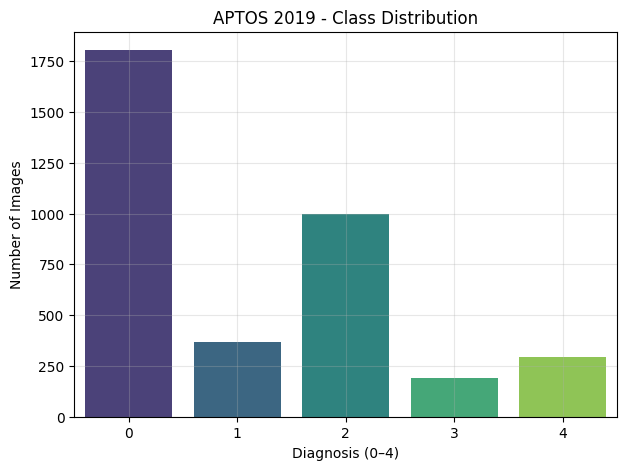

Class 0: 1805 images (49.29%)
Class 1: 370 images (10.10%)
Class 2: 999 images (27.28%)
Class 3: 193 images (5.27%)
Class 4: 295 images (8.06%)

Duplicate IDs: 0
Missing values:
 id_code      0
diagnosis    0
dtype: int64


In [6]:

# --- Column overview ---
print("Columns:", df.columns.tolist())

# --- Class distribution ---
class_counts = df['diagnosis'].value_counts().sort_index()
plt.figure(figsize=(7,5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("APTOS 2019 - Class Distribution")
plt.xlabel("Diagnosis (0–4)")
plt.ylabel("Number of Images")
plt.grid(alpha=0.3)
plt.show()

# --- Print numerical summary ---
total = len(df)
for cls, count in class_counts.items():
    pct = 100 * count / total
    print(f"Class {cls}: {count} images ({pct:.2f}%)")

# --- Check for duplicates or missing values ---
print("\nDuplicate IDs:", df['id_code'].duplicated().sum())
print("Missing values:\n", df.isna().sum())

# 3. Visual Sanity Checks

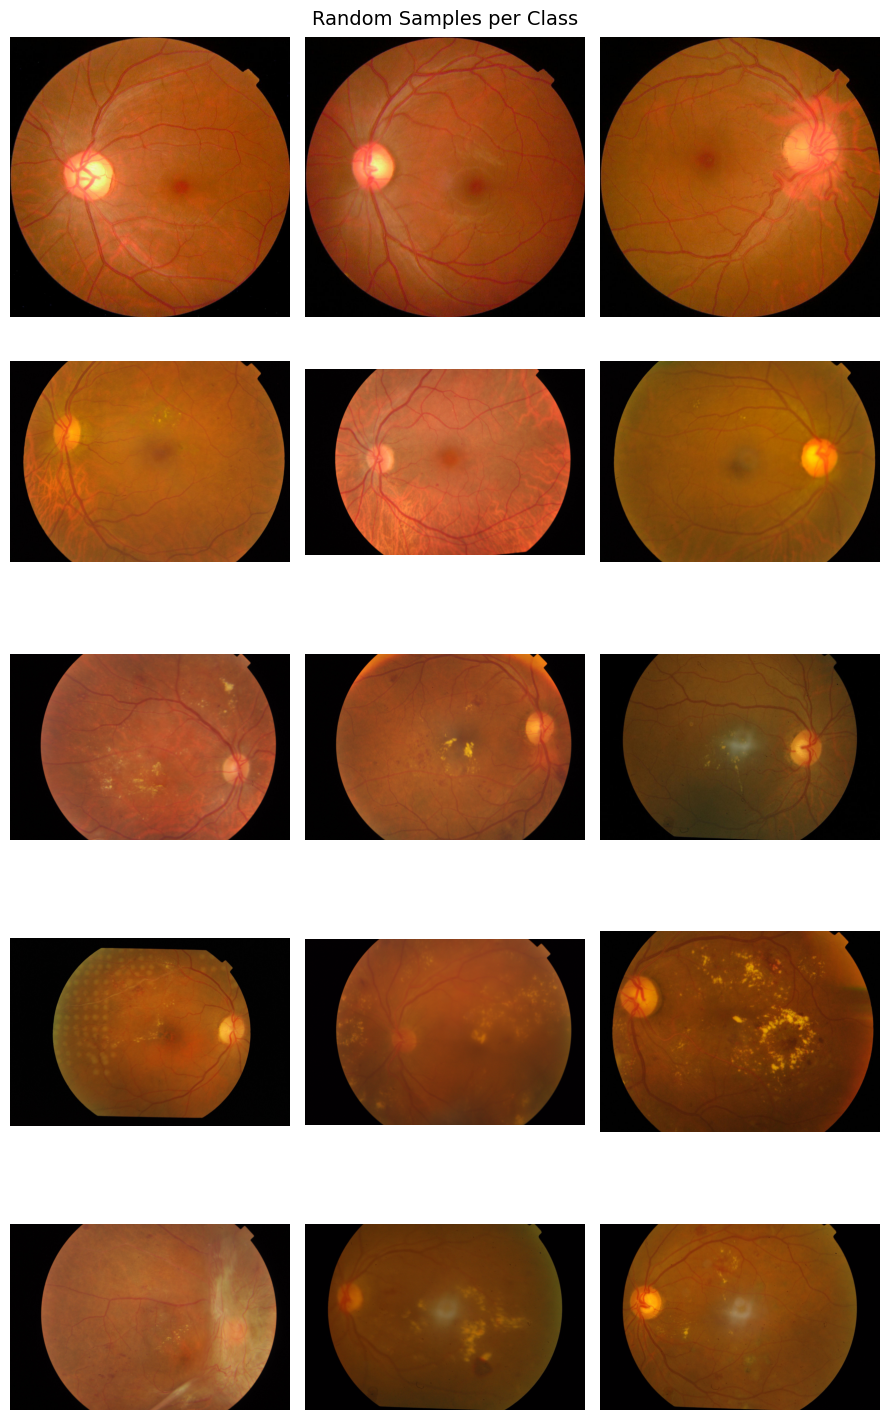

In [7]:
import math

def show_samples_per_class(df, base_dir, samples_per_class=3):
    """Displays N random samples from each class."""
    classes = sorted(df['diagnosis'].unique())
    nrows = len(classes)
    ncols = samples_per_class

    plt.figure(figsize=(ncols*3, nrows*3))
    for i, cls in enumerate(classes):
        subset = df[df['diagnosis'] == cls]
        chosen = random.sample(list(subset['id_code']), min(samples_per_class, len(subset)))
        for j, img_id in enumerate(chosen):
            img_path = base_dir / f"{img_id}.png"
            if not img_path.exists():
                continue
            img = Image.open(img_path)
            ax = plt.subplot(nrows, ncols, i*ncols + j + 1)
            ax.imshow(img)
            ax.axis("off")
            if j == 0:
                ax.set_ylabel(f"Class {cls}", fontsize=12)
    plt.suptitle("Random Samples per Class", fontsize=14)
    plt.tight_layout()
    plt.show()

show_samples_per_class(df, TRAIN_DIR)

# 4. Image Resolution Distribution (Quick Check)

Sample size analysed: 300


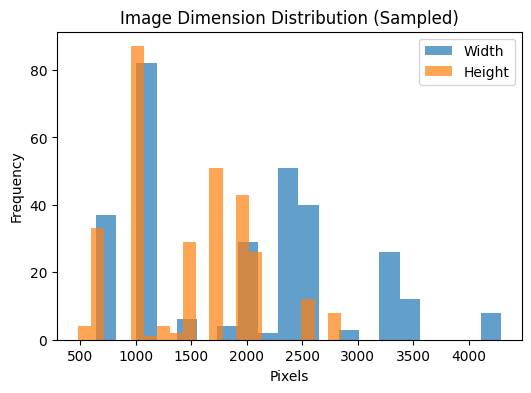

Mean size: 1965.8 x 1495.9


In [8]:
dims = []
for fname in random.sample(list(df['id_code']), min(300, len(df))):
    p = TRAIN_DIR / f"{fname}.png"
    if p.exists():
        with Image.open(p) as im:
            dims.append(im.size)
dims = np.array(dims)
print("Sample size analysed:", len(dims))

plt.figure(figsize=(6,4))
plt.hist(dims[:,0], bins=20, alpha=0.7, label="Width")
plt.hist(dims[:,1], bins=20, alpha=0.7, label="Height")
plt.legend()
plt.title("Image Dimension Distribution (Sampled)")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.show()

mean_w, mean_h = np.mean(dims, axis=0)
print(f"Mean size: {mean_w:.1f} x {mean_h:.1f}")

# Step 5 - Prepare APTOS Dataset for Training (Resize to 512×512)

In [9]:
from tqdm import tqdm

# --- Configuration ---
PREP_DIR = BASE_DIR / "train_ready_512"
RESIZE_TO = (512, 512)
OVERWRITE = False   # change to True if you want to re-generate everything

# --- Create folder structure ---
os.makedirs(PREP_DIR, exist_ok=True)
for cls in sorted(df['diagnosis'].unique()):
    os.makedirs(PREP_DIR / str(cls), exist_ok=True)

# --- Resize and save ---
print(f"Preparing resized dataset at: {PREP_DIR}")
for _, row in tqdm(df.iterrows(), total=len(df), desc="Resizing images"):
    img_id = row['id_code']
    cls = str(row['diagnosis'])
    src = TRAIN_DIR / f"{img_id}.png"
    dst = PREP_DIR / cls / f"{img_id}.png"

    if not src.exists():
        continue
    if dst.exists() and not OVERWRITE:
        continue

    with Image.open(src) as im:
        im = im.convert("RGB").resize(RESIZE_TO, Image.BICUBIC)
        im.save(dst, "PNG")

print(" All images resized and saved to:", PREP_DIR)

Preparing resized dataset at: C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\train_ready_512


Resizing images: 100%|██████████| 3662/3662 [00:00<00:00, 20760.88it/s]

 All images resized and saved to: C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\train_ready_512


In [10]:
from collections import Counter
import glob

paths = list(PREP_DIR.rglob("*.png"))
print("Total resized images:", len(paths))
print("Class distribution:", Counter(p.parent.name for p in paths))


Total resized images: 3662
Class distribution: Counter({'0': 1805, '2': 999, '1': 370, '4': 295, '3': 193})


# 6. DataLoader Sanity Check

 Scanning dataset in: C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\train_ready_512


Indexing images: 3662it [00:00, 279173.02it/s]

 Found 3662 images in 0.02s
 Loaded batch in 0.06s

 Summary
  Total images: 3662
  Batch size: 4
  Image tensor shape: torch.Size([4, 3, 512, 512])
  Labels: [0, 4, 0, 2]
  Example filenames: ('0232dfea7547.png', 'aa6673241154.png', '0d0b8fc9ab5c.png', 'aa0afc41ed19.png')


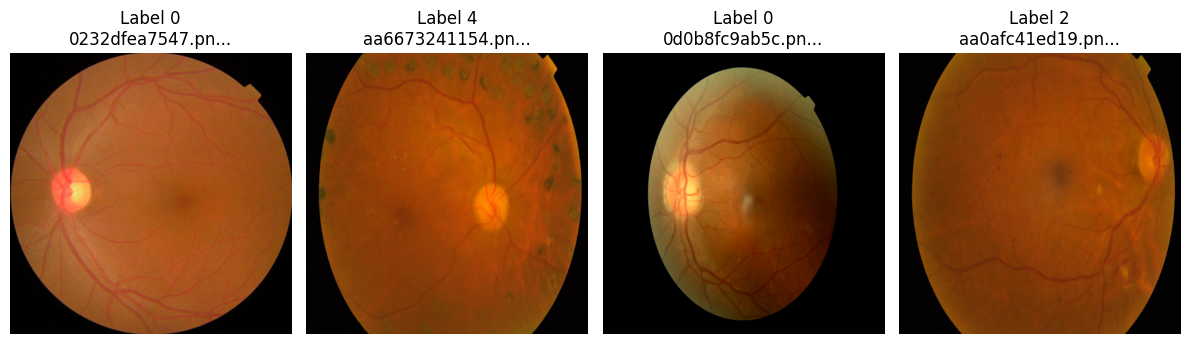

In [2]:
# ===============================================================
# STEP 6 — DATA LOADER SANITY CHECK (APTOS 2019)
# ===============================================================
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

# --- Dataset base path ---
BASE_DIR = Path(r"C:/Users/Jonathan Morel/Desktop/Honour/Data/APTOS")
TRAIN_PATH = BASE_DIR / "train_ready_512"

# ===============================================================
# Dataset Class
# ===============================================================
class APTOSDataset(Dataset):
    """Simple dataset that loads APTOS images and assigns labels based on folder names."""
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        print(f" Scanning dataset in: {self.root_dir}")
        start = time.time()

        # Build a list of image paths (with tqdm progress bar)
        self.samples = [p for p in tqdm(self.root_dir.rglob("*.png"), desc="Indexing images")]
        self.transform = transform or transforms.Compose([
            transforms.ToTensor()
        ])

        print(f" Found {len(self.samples)} images in {time.time() - start:.2f}s")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        label = int(img_path.parent.name)  # folder name = class label
        if self.transform:
            img = self.transform(img)
        return img, label, img_path.name


# ===============================================================
# Safe Loader (single-threaded for Windows)
# ===============================================================
def safe_fetch_batch(dataset, batch_size=4):
    """Loads a batch with visible timing and stability."""
    try:
        start = time.time()
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        imgs, labels, fnames = next(iter(loader))
        elapsed = time.time() - start
        print(f" Loaded batch in {elapsed:.2f}s")
        return imgs, labels, fnames
    except Exception as e:
        print(f" DataLoader failed: {e}")
        raise


# ===============================================================
# Visual Sanity Check
# ===============================================================
def show_batch(imgs, labels, fnames=None):
    n = len(imgs)
    fig, axes = plt.subplots(1, n, figsize=(12, 4))
    for i, (img, lbl) in enumerate(zip(imgs, labels)):
        img_np = np.clip(img.permute(1, 2, 0).numpy(), 0, 1)
        axes[i].imshow(img_np)
        title = f"Label {lbl.item()}"
        if fnames:
            title += f"\n{fnames[i][:15]}..."  # show partial filename
        axes[i].set_title(title)
        axes[i].axis("off")
    plt.tight_layout()
    plt.show(block=False)
    plt.pause(3)
    plt.close(fig)


# ===============================================================
# Run Loader and Display Sample
# ===============================================================
if not TRAIN_PATH.exists():
    raise FileNotFoundError(f"Dataset path not found: {TRAIN_PATH}")

dataset = APTOSDataset(TRAIN_PATH)
imgs, labels, fnames = safe_fetch_batch(dataset)

print("\n Summary")
print(f"  Total images: {len(dataset)}")
print(f"  Batch size: {len(imgs)}")
print(f"  Image tensor shape: {imgs.shape}")
print(f"  Labels: {labels.tolist()}")
print(f"  Example filenames: {fnames}")

show_batch(imgs, labels, fnames)


# STEP 7 - Create Degraded Copy of APTOS Images

In [4]:
from PIL import Image, ImageFilter, ImageEnhance
from pathlib import Path
from tqdm import tqdm
import numpy as np
import random
import io
import os

# --- Paths ---
BASE_DIR = Path(r"C:/Users/Jonathan Morel/Desktop/Honour/Data/APTOS")
SRC_DIR = BASE_DIR / "train_ready_512"
OUT_DIR = BASE_DIR / "1. Degraded_x2"
OUT_DIR.mkdir(parents=True, exist_ok=True)

def degrade_image(img: Image.Image, scale=2):
    """Simulate realistic optical + compression degradation."""
    w, h = img.size

    # Downscale & Upscale (Bicubic)
    degraded = img.resize((w // scale, h // scale), Image.BICUBIC)
    degraded = degraded.resize((w, h), Image.BICUBIC)

    # Random Gaussian Blur
    if random.random() < 0.9:  # 90% of images
        radius = random.uniform(0.8, 1.2)
        degraded = degraded.filter(ImageFilter.GaussianBlur(radius))

    # Random JPEG Compression
    buf = io.BytesIO()
    degraded.save(buf, format="JPEG", quality=random.randint(70, 90))
    buf.seek(0)
    degraded = Image.open(buf).convert("RGB")

    # Random Brightness / Contrast jitter
    if random.random() < 0.8:
        enhancer = ImageEnhance.Brightness(degraded)
        degraded = enhancer.enhance(random.uniform(0.9, 1.1))
        enhancer = ImageEnhance.Contrast(degraded)
        degraded = enhancer.enhance(random.uniform(0.9, 1.1))

    # Random Gaussian noise
    if random.random() < 0.6:
        arr = np.array(degraded).astype(np.float32)
        noise = np.random.normal(0, random.uniform(3, 6), arr.shape)
        arr = np.clip(arr + noise, 0, 255).astype(np.uint8)
        degraded = Image.fromarray(arr)

    return degraded

# --- Process ---
all_images = list(SRC_DIR.rglob("*.png"))
print(f" Found {len(all_images)} APTOS images to degrade.")

for img_path in tqdm(all_images, desc="Creating compound degraded_x2 dataset"):
    cls = img_path.parent.name
    dst_dir = OUT_DIR / cls
    dst_dir.mkdir(parents=True, exist_ok=True)
    dst_path = dst_dir / img_path.name

    img = Image.open(img_path).convert("RGB")
    degraded = degrade_image(img)
    degraded.save(dst_path, "PNG")

print(f" Compound degraded dataset created at: {OUT_DIR}")


 Found 3662 APTOS images to degrade.


Creating compound degraded_x2 dataset: 100%|██████████| 3662/3662 [03:11<00:00, 19.13it/s]

 Compound degraded dataset created at: C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\1. Degraded_x2


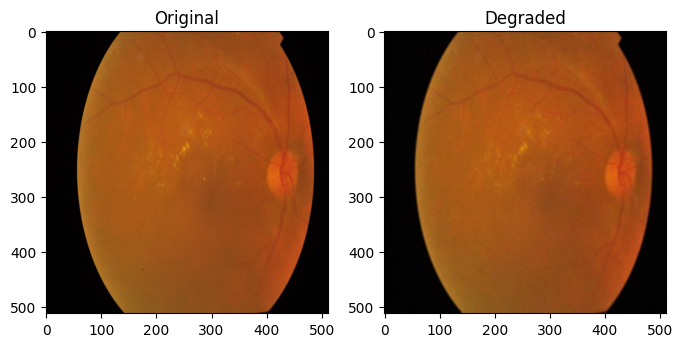

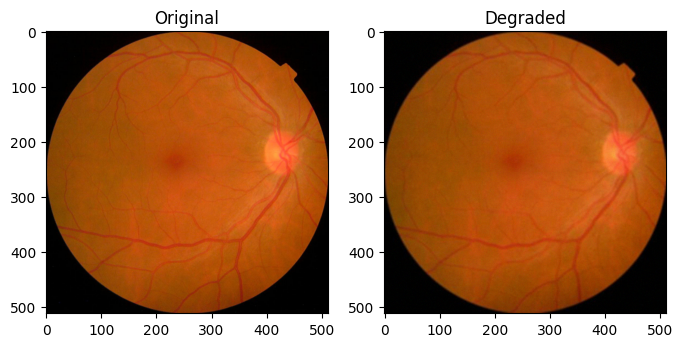

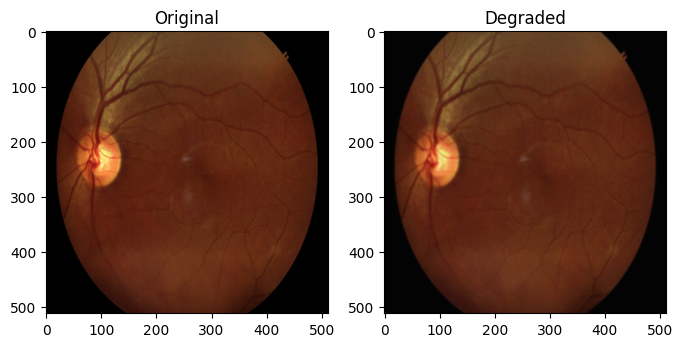

In [5]:
import numpy as np, matplotlib.pyplot as plt
imgs = [Image.open(path).convert("RGB") for path in random.sample(list(SRC_DIR.rglob("*.png")), 3)]
degraded = [degrade_image(i) for i in imgs]
for i in range(3):
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(imgs[i]); plt.title("Original")
    plt.subplot(1,2,2); plt.imshow(degraded[i]); plt.title("Degraded")
    plt.show()


In [2]:
import sys
from pathlib import Path

# Add project root (one level up from src/) to Python path
project_root = Path(r"C:/Users/Jonathan Morel/Desktop/Honour")
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# now your imports will work
from src.models.sr.srcnn import SRCNN
from src.models.sr.fsrcnn import FSRCNN
from src.models.sr.espcn import ESPCN


Testing 2 images from class 2

 Running SRCNN on 000c1434d8d7.png


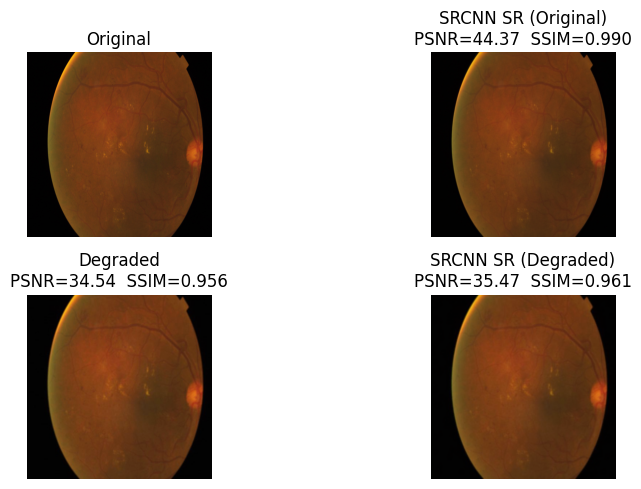

 SRCNN — PSNR gain vs degraded: 0.94 dB, SSIM gain: 0.005

 Running FSRCNN on 000c1434d8d7.png


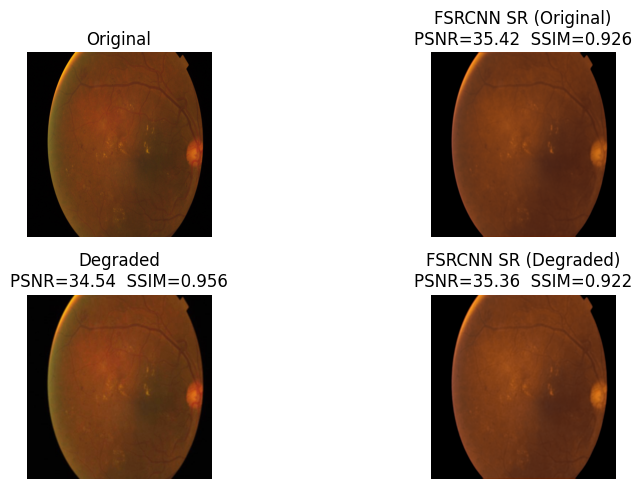

 FSRCNN — PSNR gain vs degraded: 0.82 dB, SSIM gain: -0.034

 Running ESPCN on 000c1434d8d7.png


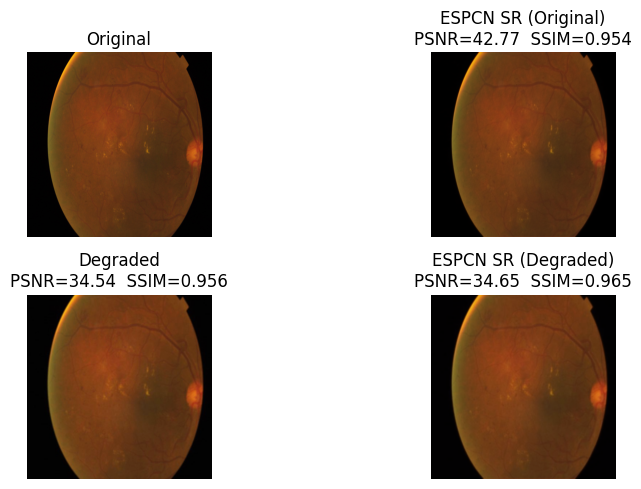

 ESPCN — PSNR gain vs degraded: 0.12 dB, SSIM gain: 0.010

 Running SRCNN on 00a8624548a9.png


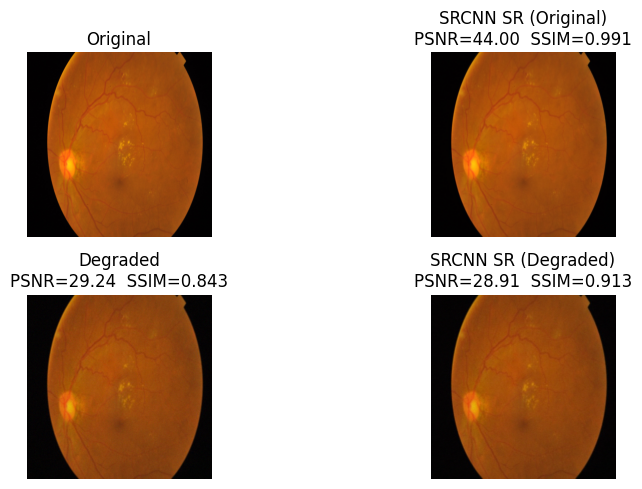

 SRCNN — PSNR gain vs degraded: -0.33 dB, SSIM gain: 0.070

 Running FSRCNN on 00a8624548a9.png


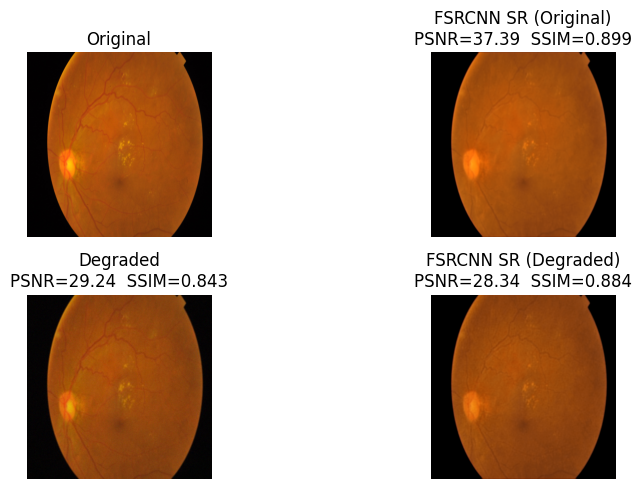

 FSRCNN — PSNR gain vs degraded: -0.90 dB, SSIM gain: 0.041

 Running ESPCN on 00a8624548a9.png


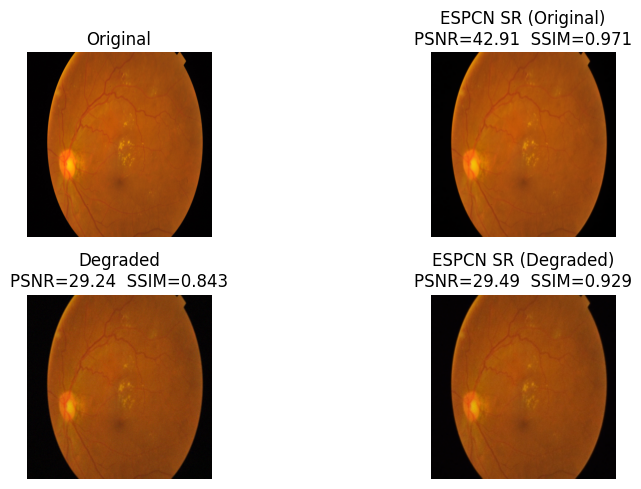

 ESPCN — PSNR gain vs degraded: 0.25 dB, SSIM gain: 0.086


In [5]:
# ===============================================================
# APTOS SR Smoke Test — Visual + PSNR/SSIM Comparison
# ===============================================================
import sys
from pathlib import Path
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import numpy as np

# ===============================================================
# PATH SETUP
# ===============================================================
project_root = Path(r"C:/Users/Jonathan Morel/Desktop/Honour")
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import models
from src.models.sr.srcnn import SRCNN
from src.models.sr.fsrcnn import FSRCNN
from src.models.sr.espcn import ESPCN

BASE_DIR   = project_root / "Data" / "APTOS"
MODEL_DIR  = project_root / "outputs" / "sr_models"
OUT_DIR    = project_root / "outputs" / "APTOS_smoke_test_metrics"
OUT_DIR.mkdir(parents=True, exist_ok=True)

ORIGINAL_DIR = BASE_DIR / "train_ready_512"
DEGRADED_DIR = BASE_DIR / "1. Degraded_x2"

SR_MODELS = {
    "srcnn":  (MODEL_DIR / "srcnn_best.pt", SRCNN),
    "fsrcnn": (MODEL_DIR / "fsrcnn_best.pt", FSRCNN),
    "espcn":  (MODEL_DIR / "espcn_best.pt", ESPCN),
}

device = "cuda" if torch.cuda.is_available() else "cpu"
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

# ===============================================================
# HELPER FUNCTIONS
# ===============================================================
def compute_metrics(hr_img: Image.Image, test_img: Image.Image):
    """Compute PSNR/SSIM between two RGB images (Y-channel)."""
    hr = np.array(hr_img.convert("L"), dtype=np.uint8)
    test = np.array(test_img.convert("L"), dtype=np.uint8)
    psnr_val = psnr(hr, test, data_range=255)
    ssim_val = ssim(hr, test, data_range=255)
    return psnr_val, ssim_val

def safe_load_state(model, ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=device)
    if "state_dict" in ckpt:
        model_state = ckpt["state_dict"]
    elif "model" in ckpt:
        model_state = ckpt["model"]
    else:
        model_state = ckpt
    target = model._m if hasattr(model, "_m") else model
    target.load_state_dict(model_state, strict=False)
    return target.eval()

# ===============================================================
# SAMPLE SELECTION
# ===============================================================
sample_class = "2"
sample_paths = list((DEGRADED_DIR / sample_class).glob("*.png"))[:2]
print(f"Testing {len(sample_paths)} images from class {sample_class}")

# ===============================================================
# MAIN LOOP
# ===============================================================
for sample_path in sample_paths:
    degraded_img = Image.open(sample_path).convert("RGB")
    original_img = Image.open(ORIGINAL_DIR / sample_class / sample_path.name).convert("RGB")

    for model_name, (ckpt_path, model_class) in SR_MODELS.items():
        print(f"\n Running {model_name.upper()} on {sample_path.name}")

        try:
            model = model_class(scale_factor=2).to(device)
        except TypeError:
            model = model_class().to(device)

        model = safe_load_state(model, ckpt_path)

        # SR on degraded + original
        with torch.no_grad():
            x_deg = to_tensor(degraded_img).unsqueeze(0).to(device)
            sr_deg_img = to_pil(model(x_deg).squeeze().cpu().clamp(0, 1))

            x_org = to_tensor(original_img).unsqueeze(0).to(device)
            sr_org_img = to_pil(model(x_org).squeeze().cpu().clamp(0, 1))

        # ---- Metrics ----
        psnr_deg, ssim_deg = compute_metrics(original_img, sr_deg_img)
        psnr_org, ssim_org = compute_metrics(original_img, sr_org_img)
        base_psnr, base_ssim = compute_metrics(original_img, degraded_img)

        # ---- Save outputs ----
        save_dir = OUT_DIR / model_name
        save_dir.mkdir(parents=True, exist_ok=True)
        sr_deg_img.save(save_dir / f"{sample_path.stem}_SR_from_degraded.png")
        sr_org_img.save(save_dir / f"{sample_path.stem}_SR_from_original.png")

        # ---- Display results ----
        fig, axes = plt.subplots(2, 2, figsize=(10, 5))
        axes[0,0].imshow(original_img); axes[0,0].set_title("Original"); axes[0,0].axis("off")
        axes[0,1].imshow(sr_org_img); axes[0,1].set_title(f"{model_name.upper()} SR (Original)\nPSNR={psnr_org:.2f}  SSIM={ssim_org:.3f}"); axes[0,1].axis("off")
        axes[1,0].imshow(degraded_img); axes[1,0].set_title(f"Degraded\nPSNR={base_psnr:.2f}  SSIM={base_ssim:.3f}"); axes[1,0].axis("off")
        axes[1,1].imshow(sr_deg_img); axes[1,1].set_title(f"{model_name.upper()} SR (Degraded)\nPSNR={psnr_deg:.2f}  SSIM={ssim_deg:.3f}"); axes[1,1].axis("off")
        plt.tight_layout()
        plt.show()

        print(f" {model_name.upper()} — PSNR gain vs degraded: {psnr_deg - base_psnr:.2f} dB, SSIM gain: {ssim_deg - base_ssim:.3f}")



In [1]:
# ===============================================================
# APTOS FULL SR PIPELINE — BATCH INFERENCE + METRICS LOGGING
# ===============================================================
import sys, csv, os
from pathlib import Path
from PIL import Image
import torch
from torchvision import transforms
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import numpy as np
from tqdm import tqdm

# ===============================================================
# PATH CONFIGURATION
# ===============================================================
project_root = Path(r"C:/Users/Jonathan Morel/Desktop/Honour")
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# --- Model imports ---
from src.models.sr.srcnn import SRCNN
from src.models.sr.fsrcnn import FSRCNN
from src.models.sr.espcn import ESPCN

# --- Data & Output paths ---
BASE_DIR   = project_root / "Data" / "APTOS"
MODEL_DIR  = project_root / "outputs" / "sr_models"
OUT_DIR    = project_root / "outputs" / "APTOS_SR_full"
OUT_DIR.mkdir(parents=True, exist_ok=True)

ORIGINAL_DIR = BASE_DIR / "train_ready_512"
DEGRADED_DIR = BASE_DIR / "1. Degraded_x2"

# --- SR Models ---
SR_MODELS = {
    "srcnn":  (MODEL_DIR / "srcnn_best.pt", SRCNN),
    "fsrcnn": (MODEL_DIR / "fsrcnn_best.pt", FSRCNN),
    "espcn":  (MODEL_DIR / "espcn_best.pt", ESPCN),
}

device = "cuda" if torch.cuda.is_available() else "cpu"
to_tensor, to_pil = transforms.ToTensor(), transforms.ToPILImage()

# ===============================================================
# HELPER FUNCTIONS
# ===============================================================
def compute_metrics(hr_img: Image.Image, test_img: Image.Image):
    """Compute PSNR and SSIM between two images (grayscale)."""
    hr = np.array(hr_img.convert("L"), dtype=np.uint8)
    test = np.array(test_img.convert("L"), dtype=np.uint8)
    return psnr(hr, test, data_range=255), ssim(hr, test, data_range=255)

def safe_load_state(model, ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=device)
    if "state_dict" in ckpt: model_state = ckpt["state_dict"]
    elif "model" in ckpt: model_state = ckpt["model"]
    else: model_state = ckpt
    target = model._m if hasattr(model, "_m") else model
    target.load_state_dict(model_state, strict=False)
    return target.eval()

# ===============================================================
# METRICS LOGGER SETUP
# ===============================================================
log_path = OUT_DIR / "sr_metrics.csv"
if not log_path.exists():
    with open(log_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "image_id", "model", 
            "psnr_degraded", "ssim_degraded",
            "psnr_sr_degraded", "ssim_sr_degraded",
            "psnr_sr_original", "ssim_sr_original"
        ])

# ===============================================================
# MAIN PIPELINE
# ===============================================================
for model_name, (ckpt_path, model_class) in SR_MODELS.items():
    print(f"\n Running {model_name.upper()} across APTOS dataset")
    save_base = OUT_DIR / model_name
    (save_base / "SR_on_degraded").mkdir(parents=True, exist_ok=True)
    (save_base / "SR_on_original").mkdir(parents=True, exist_ok=True)

    # Instantiate model
    try:
        model = model_class(scale_factor=2).to(device)
    except TypeError:
        model = model_class().to(device)
    model = safe_load_state(model, ckpt_path)

    # Iterate classes
    for class_dir in sorted(os.listdir(DEGRADED_DIR)):
        deg_class_path = DEGRADED_DIR / class_dir
        org_class_path = ORIGINAL_DIR / class_dir
        if not deg_class_path.is_dir(): continue

        for img_path in tqdm(list(deg_class_path.glob("*.png")), desc=f"Class {class_dir}"):
            try:
                # Skip if already processed
                out_file = save_base / "SR_on_degraded" / class_dir / img_path.name
                if out_file.exists():
                    continue

                degraded_img = Image.open(img_path).convert("RGB")
                original_img = Image.open(org_class_path / img_path.name).convert("RGB")

                # --- Run SR ---
                with torch.no_grad():
                    x_deg = to_tensor(degraded_img).unsqueeze(0).to(device)
                    sr_deg_img = to_pil(model(x_deg).squeeze().cpu().clamp(0, 1))

                    x_org = to_tensor(original_img).unsqueeze(0).to(device)
                    sr_org_img = to_pil(model(x_org).squeeze().cpu().clamp(0, 1))

                # --- Compute metrics ---
                psnr_deg, ssim_deg = compute_metrics(original_img, degraded_img)
                psnr_sr_deg, ssim_sr_deg = compute_metrics(original_img, sr_deg_img)
                psnr_sr_org, ssim_sr_org = compute_metrics(original_img, sr_org_img)

                # --- Save outputs ---
                out_deg_class = save_base / "SR_on_degraded" / class_dir
                out_org_class = save_base / "SR_on_original" / class_dir
                out_deg_class.mkdir(parents=True, exist_ok=True)
                out_org_class.mkdir(parents=True, exist_ok=True)

                sr_deg_img.save(out_deg_class / img_path.name)
                sr_org_img.save(out_org_class / img_path.name)

                # --- Append to CSV ---
                with open(log_path, "a", newline="") as f:
                    writer = csv.writer(f)
                    writer.writerow([
                        img_path.stem, model_name,
                        f"{psnr_deg:.3f}", f"{ssim_deg:.4f}",
                        f"{psnr_sr_deg:.3f}", f"{ssim_sr_deg:.4f}",
                        f"{psnr_sr_org:.3f}", f"{ssim_sr_org:.4f}"
                    ])

            except Exception as e:
                print(f"[WARN] Skipped {img_path.name} due to error: {e}")

print("\n SR Full Inference Complete — metrics logged to sr_metrics.csv")



 Running SRCNN across APTOS dataset


Class 4: 100%|██████████| 295/295 [01:14<00:00,  3.96it/s]



 Running FSRCNN across APTOS dataset


Class 4: 100%|██████████| 295/295 [01:06<00:00,  4.45it/s]



 Running ESPCN across APTOS dataset


Class 4: 100%|██████████| 295/295 [01:04<00:00,  4.56it/s]


 SR Full Inference Complete — metrics logged to sr_metrics.csv


In [5]:
# =======================
# APTOS — SR QUALITY ROLLUP
# =======================
import pandas as pd
from pathlib import Path

APTOS_BASE   = Path(r"C:/Users/Jonathan Morel/Desktop/Honour/Data/APTOS")
SR_OUT_DIR   = Path(r"C:/Users/Jonathan Morel/Desktop/Honour/outputs/APTOS_SR_full")
SR_METRICS   = SR_OUT_DIR / "sr_metrics.csv"           # produced by your full SR pipeline
TRAIN_CSV    = APTOS_BASE / "train.csv"                # id_code, diagnosis (0..4)

# --- Load ---
df = pd.read_csv(SR_METRICS)
df.columns = df.columns.str.strip()
lab = pd.read_csv(TRAIN_CSV)[["id_code","diagnosis"]]
lab["image_id"] = lab["id_code"].astype(str)

# --- Merge labels (class) ---
df = df.merge(lab[["image_id","diagnosis"]], on="image_id", how="left")

# --- numeric cast ---
for c in df.columns:
  if c not in ["image_id","model"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# --- Overall per-model (matches your IDRiD rollup) ---
overall = (
    df.groupby("model")[[
        "psnr_degraded","ssim_degraded",
        "psnr_sr_degraded","ssim_sr_degraded",
        "psnr_sr_original","ssim_sr_original"
    ]].mean().reset_index()
)
overall_path = SR_OUT_DIR / "sr_overall_summary.csv"
overall.to_csv(overall_path, index=False)

# --- Per-class per-model (0..4) ---
per_class = (
    df.groupby(["model","diagnosis"])[[
        "psnr_degraded","ssim_degraded",
        "psnr_sr_degraded","ssim_sr_degraded",
        "psnr_sr_original","ssim_sr_original"
    ]].mean().reset_index().sort_values(["model","diagnosis"])
)
per_class_path = SR_OUT_DIR / "sr_per_class_summary.csv"
per_class.to_csv(per_class_path, index=False)

# --- Pretty print ---
print("\n=== OVERALL (per model) ===")
for _,r in overall.iterrows():
    print(f"\n{r['model'].upper()}")
    print(f"  PSNR (Deg)  : {r['psnr_degraded']:.2f} | SSIM (Deg)  : {r['ssim_degraded']:.4f}")
    print(f"  PSNR (SR@Deg): {r['psnr_sr_degraded']:.2f} | SSIM (SR@Deg): {r['ssim_sr_degraded']:.4f}")
    print(f"  PSNR (SR@Org): {r['psnr_sr_original']:.2f} | SSIM (SR@Org): {r['ssim_sr_original']:.4f}")

print(f"\nSaved: {overall_path}")
print(f"Saved: {per_class_path}")



=== OVERALL (per model) ===

ESPCN
  PSNR (Deg)  : 34.53 | SSIM (Deg)  : 0.8670
  PSNR (SR@Deg): 34.56 | SSIM (SR@Deg): 0.9204
  PSNR (SR@Org): 41.59 | SSIM (SR@Org): 0.9720

FSRCNN
  PSNR (Deg)  : 34.53 | SSIM (Deg)  : 0.8670
  PSNR (SR@Deg): 30.93 | SSIM (SR@Deg): 0.8892
  PSNR (SR@Org): 32.86 | SSIM (SR@Org): 0.9022

SRCNN
  PSNR (Deg)  : 34.53 | SSIM (Deg)  : 0.8670
  PSNR (SR@Deg): 35.02 | SSIM (SR@Deg): 0.9111
  PSNR (SR@Org): 44.66 | SSIM (SR@Org): 0.9871

Saved: C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\sr_overall_summary.csv
Saved: C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\sr_per_class_summary.csv


# APTOS Deep Learning Benchmark Script

In [ ]:
# ===============================================================
# FULL TRAINING SUITE — APTOS 2019 Images (Baseline Classifiers)
# ===============================================================
import os, time, torch, torchvision, numpy as np, pandas as pd
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, f1_score
from PIL import Image
from pathlib import Path

# ------------------- CONFIG -------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH = 32
EPOCHS = 40
LR = 2e-4
WEIGHT_DECAY = 1e-4

# === PATHS ===
BASE_DIR = Path(r"C:/Users/Jonathan Morel/Desktop/Honour/Data/APTOS")
IMG_DIR = BASE_DIR / "train_ready_512"
CSV_PATH = BASE_DIR / "train.csv"

OUT_DIR = Path("outputs/APTOS_DL_Benchmark/models")
LOG_DIR = Path("outputs/APTOS_DL_Benchmark/logs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

print(f"Device: {device}")
print("Training source:", IMG_DIR)

# ------------------- LOAD LABELS -------------------
df = pd.read_csv(CSV_PATH)[["id_code", "diagnosis"]]
df.columns = ["image", "label"]
df["image"] = df["image"].astype(str)
df["label"] = df["label"].astype(int)
NUM_CLASSES = len(df["label"].unique())
print(f"Loaded {len(df)} images | Classes: {NUM_CLASSES}")

# ------------------- DATASET -------------------
class APTOSDataset(Dataset):
    def __init__(self, root, df, transform):
        self.root = Path(root)
        self.samples = []
        for _, r in df.iterrows():
            img_path = self.root / str(r["label"]) / f"{r['image']}.png"
            if img_path.exists():
                self.samples.append((img_path, int(r["label"])))
        self.transform = transform
        print(f"Matched {len(self.samples)}/{len(df)} available images.")

    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        p, y = self.samples[i]
        x = Image.open(p).convert("RGB")
        return self.transform(x), y

tfm_train = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
tfm_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

dataset = APTOSDataset(IMG_DIR, df, tfm_train)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
val_ds.dataset.transform = tfm_val

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=0)

# ------------------- TRAINING LOOP -------------------
def train_model(model_name, builder):
    print(f"\n{'='*60}\n Training {model_name}\n{'='*60}")
    model = builder().to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    loss_fn = torch.nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
    best_acc, log = 0, []

    for ep in range(1, EPOCHS+1):
        t0 = time.time()
        model.train()
        total_loss = 0
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=True):
                logits = model(x)
                loss = loss_fn(logits, y)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)

        # validation
        model.eval()
        preds,gts=[],[]
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):
            for x,y in val_loader:
                x,y = x.to(device), y.to(device)
                logits = model(x)
                preds.extend(torch.argmax(logits,1).cpu().numpy())
                gts.extend(y.cpu().numpy())
        acc = accuracy_score(gts,preds)
        f1 = f1_score(gts,preds,average="macro")
        log.append([ep,avg_loss,acc,f1])
        print(f"Epoch {ep:02d}/{EPOCHS:02d} | Loss={avg_loss:.4f} | Acc={acc:.4f} | F1={f1:.4f} | Time={time.time()-t0:.1f}s")

        # save best
        if acc > best_acc:
            best_acc = acc
            ckpt = OUT_DIR / f"{model_name}_best.pt"
            torch.save(model.state_dict(), ckpt)
            print(f"  ↳ Saved best model: {ckpt}")

    # Save log
    log_path = LOG_DIR / f"{model_name}_trainlog.csv"
    pd.DataFrame(log, columns=["epoch","loss","accuracy","macro_f1"]).to_csv(log_path,index=False)
    print(f" Log saved: {log_path}\nBest accuracy: {best_acc:.4f}")
    return model

# ------------------- MODEL BUILDERS -------------------
def build_resnet50():
    m = models.resnet50(weights="IMAGENET1K_V1")
    m.fc = torch.nn.Linear(m.fc.in_features, NUM_CLASSES)
    return m

def build_efficientnet_b3():
    m = models.efficientnet_b3(weights="IMAGENET1K_V1")
    m.classifier[1] = torch.nn.Linear(m.classifier[1].in_features, NUM_CLASSES)
    return m

def build_convnext_tiny():
    m = models.convnext_tiny(weights="IMAGENET1K_V1")
    m.classifier[2] = torch.nn.Linear(m.classifier[2].in_features, NUM_CLASSES)
    return m

def build_vit_b16():
    m = models.vit_b_16(weights="IMAGENET1K_V1")
    m.heads.head = torch.nn.Linear(m.heads.head.in_features, NUM_CLASSES)
    return m

# ------------------- TRAIN ALL -------------------
train_model("resnet50_classifier", build_resnet50)
train_model("efficientnet_b3_classifier", build_efficientnet_b3)
train_model("convnext_tiny_classifier", build_convnext_tiny)
train_model("vit_b16_classifier", build_vit_b16)
 
print("\n All trainings complete — check /outputs/APTOS_DL_Benchmark/ for best checkpoints.")


Device: cuda
Training source: C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\train_ready_512
Loaded 3662 images | Classes: 5
Matched 3662/3662 available images.

▶ Training resnet50_classifier


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:87: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 01/40 | Loss=0.6366 | Acc=0.7694 | F1=0.5373 | Time=31.1s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\resnet50_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 02/40 | Loss=0.4433 | Acc=0.8035 | F1=0.6339 | Time=28.5s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\resnet50_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 03/40 | Loss=0.3241 | Acc=0.8295 | F1=0.6561 | Time=28.2s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\resnet50_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 04/40 | Loss=0.2343 | Acc=0.7954 | F1=0.5861 | Time=30.2s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 05/40 | Loss=0.1990 | Acc=0.8158 | F1=0.6425 | Time=30.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 06/40 | Loss=0.1562 | Acc=0.8063 | F1=0.6371 | Time=29.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 07/40 | Loss=0.1084 | Acc=0.8240 | F1=0.5957 | Time=29.2s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 08/40 | Loss=0.1082 | Acc=0.8199 | F1=0.6599 | Time=29.2s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 09/40 | Loss=0.0681 | Acc=0.8158 | F1=0.6704 | Time=29.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 10/40 | Loss=0.0667 | Acc=0.8240 | F1=0.6465 | Time=29.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 11/40 | Loss=0.0788 | Acc=0.8349 | F1=0.6671 | Time=29.3s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\resnet50_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 12/40 | Loss=0.0828 | Acc=0.8308 | F1=0.6532 | Time=29.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 13/40 | Loss=0.0691 | Acc=0.8267 | F1=0.6623 | Time=29.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 14/40 | Loss=0.0608 | Acc=0.8022 | F1=0.5990 | Time=29.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 15/40 | Loss=0.0615 | Acc=0.8308 | F1=0.6591 | Time=29.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 16/40 | Loss=0.0471 | Acc=0.8336 | F1=0.6741 | Time=29.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 17/40 | Loss=0.0316 | Acc=0.8336 | F1=0.6671 | Time=29.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 18/40 | Loss=0.0240 | Acc=0.8377 | F1=0.6842 | Time=29.4s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\resnet50_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 19/40 | Loss=0.0217 | Acc=0.8226 | F1=0.6548 | Time=29.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 20/40 | Loss=0.0213 | Acc=0.8267 | F1=0.6733 | Time=29.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 21/40 | Loss=0.0175 | Acc=0.8349 | F1=0.6671 | Time=29.3s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 22/40 | Loss=0.0180 | Acc=0.8254 | F1=0.6438 | Time=29.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 23/40 | Loss=0.0161 | Acc=0.8308 | F1=0.6537 | Time=29.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 24/40 | Loss=0.0205 | Acc=0.8281 | F1=0.6570 | Time=29.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 25/40 | Loss=0.0178 | Acc=0.8172 | F1=0.6272 | Time=29.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 26/40 | Loss=0.0197 | Acc=0.8199 | F1=0.6744 | Time=29.3s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 27/40 | Loss=0.0433 | Acc=0.7640 | F1=0.5468 | Time=29.3s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 28/40 | Loss=0.2947 | Acc=0.8117 | F1=0.5769 | Time=29.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 29/40 | Loss=0.1319 | Acc=0.8131 | F1=0.6415 | Time=29.3s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 30/40 | Loss=0.0633 | Acc=0.8240 | F1=0.6617 | Time=29.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 31/40 | Loss=0.0407 | Acc=0.8186 | F1=0.6118 | Time=29.3s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 32/40 | Loss=0.0288 | Acc=0.8240 | F1=0.6493 | Time=29.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 33/40 | Loss=0.0227 | Acc=0.8377 | F1=0.6664 | Time=29.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 34/40 | Loss=0.0198 | Acc=0.8390 | F1=0.6738 | Time=29.6s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\resnet50_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 35/40 | Loss=0.0191 | Acc=0.8336 | F1=0.6642 | Time=29.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 36/40 | Loss=0.0178 | Acc=0.8390 | F1=0.6649 | Time=29.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 37/40 | Loss=0.0204 | Acc=0.8240 | F1=0.6458 | Time=29.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 38/40 | Loss=0.0247 | Acc=0.8145 | F1=0.6347 | Time=29.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 39/40 | Loss=0.1295 | Acc=0.7790 | F1=0.5744 | Time=29.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 40/40 | Loss=0.1581 | Acc=0.7790 | F1=0.6278 | Time=29.5s
 Log saved: outputs\APTOS_DL_Benchmark\logs\resnet50_classifier_trainlog.csv
Best accuracy: 0.8390

▶ Training efficientnet_b3_classifier


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:87: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 01/40 | Loss=0.8055 | Acc=0.8172 | F1=0.5372 | Time=50.2s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\efficientnet_b3_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 02/40 | Loss=0.4572 | Acc=0.8254 | F1=0.6492 | Time=31.8s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\efficientnet_b3_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 03/40 | Loss=0.2957 | Acc=0.8199 | F1=0.6656 | Time=31.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 04/40 | Loss=0.1925 | Acc=0.8308 | F1=0.6513 | Time=31.9s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\efficientnet_b3_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 05/40 | Loss=0.1392 | Acc=0.8281 | F1=0.6387 | Time=31.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 06/40 | Loss=0.1154 | Acc=0.8308 | F1=0.6778 | Time=31.3s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 07/40 | Loss=0.0933 | Acc=0.8199 | F1=0.6442 | Time=31.3s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 08/40 | Loss=0.0667 | Acc=0.8322 | F1=0.6655 | Time=31.6s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\efficientnet_b3_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 09/40 | Loss=0.0658 | Acc=0.8226 | F1=0.6631 | Time=31.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 10/40 | Loss=0.0638 | Acc=0.8363 | F1=0.6763 | Time=31.5s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\efficientnet_b3_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 11/40 | Loss=0.0601 | Acc=0.8322 | F1=0.6781 | Time=31.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 12/40 | Loss=0.0633 | Acc=0.8336 | F1=0.6961 | Time=31.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 13/40 | Loss=0.0536 | Acc=0.8349 | F1=0.6787 | Time=31.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 14/40 | Loss=0.0409 | Acc=0.8322 | F1=0.6499 | Time=31.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 15/40 | Loss=0.0466 | Acc=0.8404 | F1=0.6938 | Time=31.4s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\efficientnet_b3_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 16/40 | Loss=0.0460 | Acc=0.8254 | F1=0.6531 | Time=31.3s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 17/40 | Loss=0.0482 | Acc=0.8322 | F1=0.6767 | Time=31.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 18/40 | Loss=0.0311 | Acc=0.8363 | F1=0.6836 | Time=31.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 19/40 | Loss=0.0309 | Acc=0.8417 | F1=0.6900 | Time=31.8s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\efficientnet_b3_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 20/40 | Loss=0.0343 | Acc=0.8226 | F1=0.6442 | Time=31.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 21/40 | Loss=0.0491 | Acc=0.8295 | F1=0.6494 | Time=31.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 22/40 | Loss=0.0393 | Acc=0.8295 | F1=0.6692 | Time=31.9s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 23/40 | Loss=0.0409 | Acc=0.8390 | F1=0.6828 | Time=32.0s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 24/40 | Loss=0.0373 | Acc=0.8322 | F1=0.6725 | Time=31.9s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 25/40 | Loss=0.0294 | Acc=0.8349 | F1=0.6692 | Time=31.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 26/40 | Loss=0.0246 | Acc=0.8377 | F1=0.6763 | Time=31.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 27/40 | Loss=0.0263 | Acc=0.8240 | F1=0.6424 | Time=31.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 28/40 | Loss=0.0376 | Acc=0.8349 | F1=0.6923 | Time=31.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 29/40 | Loss=0.0266 | Acc=0.8322 | F1=0.6709 | Time=31.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 30/40 | Loss=0.0247 | Acc=0.8267 | F1=0.6499 | Time=31.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 31/40 | Loss=0.0327 | Acc=0.8226 | F1=0.6509 | Time=31.2s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 32/40 | Loss=0.0351 | Acc=0.8336 | F1=0.6848 | Time=31.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 33/40 | Loss=0.0287 | Acc=0.8267 | F1=0.6687 | Time=31.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 34/40 | Loss=0.0257 | Acc=0.8363 | F1=0.6713 | Time=31.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 35/40 | Loss=0.0326 | Acc=0.8308 | F1=0.6651 | Time=31.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 36/40 | Loss=0.0376 | Acc=0.8172 | F1=0.6322 | Time=31.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 37/40 | Loss=0.0297 | Acc=0.8172 | F1=0.6571 | Time=31.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 38/40 | Loss=0.0335 | Acc=0.8404 | F1=0.6880 | Time=31.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 39/40 | Loss=0.0264 | Acc=0.8349 | F1=0.6635 | Time=31.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 40/40 | Loss=0.0316 | Acc=0.8254 | F1=0.6480 | Time=31.4s
 Log saved: outputs\APTOS_DL_Benchmark\logs\efficientnet_b3_classifier_trainlog.csv
Best accuracy: 0.8417

▶ Training convnext_tiny_classifier


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:87: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 01/40 | Loss=0.6752 | Acc=0.8308 | F1=0.5857 | Time=46.7s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\convnext_tiny_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 02/40 | Loss=0.4039 | Acc=0.8336 | F1=0.6735 | Time=30.8s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\convnext_tiny_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 03/40 | Loss=0.3089 | Acc=0.8417 | F1=0.6612 | Time=30.7s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\convnext_tiny_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 04/40 | Loss=0.2099 | Acc=0.8295 | F1=0.6855 | Time=30.2s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 05/40 | Loss=0.1418 | Acc=0.8336 | F1=0.6708 | Time=30.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 06/40 | Loss=0.0968 | Acc=0.8308 | F1=0.6772 | Time=30.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 07/40 | Loss=0.0675 | Acc=0.8390 | F1=0.6980 | Time=30.9s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 08/40 | Loss=0.0607 | Acc=0.8390 | F1=0.6582 | Time=30.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 09/40 | Loss=0.0517 | Acc=0.8390 | F1=0.6653 | Time=30.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 10/40 | Loss=0.0647 | Acc=0.8308 | F1=0.6482 | Time=30.3s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 11/40 | Loss=0.0674 | Acc=0.8431 | F1=0.6605 | Time=30.8s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\convnext_tiny_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 12/40 | Loss=0.0699 | Acc=0.8322 | F1=0.6817 | Time=30.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 13/40 | Loss=0.0555 | Acc=0.8404 | F1=0.6783 | Time=30.3s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 14/40 | Loss=0.0738 | Acc=0.8349 | F1=0.6715 | Time=30.3s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 15/40 | Loss=0.0334 | Acc=0.8349 | F1=0.6819 | Time=30.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 16/40 | Loss=0.0258 | Acc=0.8390 | F1=0.6828 | Time=30.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 17/40 | Loss=0.0478 | Acc=0.8322 | F1=0.6986 | Time=30.3s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 18/40 | Loss=0.0318 | Acc=0.8445 | F1=0.6830 | Time=30.5s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\convnext_tiny_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 19/40 | Loss=0.0245 | Acc=0.8527 | F1=0.6994 | Time=30.9s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\convnext_tiny_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 20/40 | Loss=0.0283 | Acc=0.8568 | F1=0.7266 | Time=30.8s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\convnext_tiny_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 21/40 | Loss=0.0271 | Acc=0.8281 | F1=0.6913 | Time=30.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 22/40 | Loss=0.0234 | Acc=0.8322 | F1=0.6503 | Time=30.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 23/40 | Loss=0.0614 | Acc=0.8008 | F1=0.6390 | Time=30.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 24/40 | Loss=0.1091 | Acc=0.8377 | F1=0.6569 | Time=30.9s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 25/40 | Loss=0.0816 | Acc=0.8458 | F1=0.6559 | Time=30.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 26/40 | Loss=0.0471 | Acc=0.8458 | F1=0.6807 | Time=30.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 27/40 | Loss=0.0237 | Acc=0.8417 | F1=0.6927 | Time=30.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 28/40 | Loss=0.0195 | Acc=0.8458 | F1=0.6888 | Time=30.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 29/40 | Loss=0.0232 | Acc=0.8090 | F1=0.6558 | Time=30.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 30/40 | Loss=0.0529 | Acc=0.8377 | F1=0.6478 | Time=30.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 31/40 | Loss=0.0372 | Acc=0.8390 | F1=0.6823 | Time=30.3s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 32/40 | Loss=0.0336 | Acc=0.8349 | F1=0.6825 | Time=30.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 33/40 | Loss=0.0265 | Acc=0.8336 | F1=0.6439 | Time=30.2s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 34/40 | Loss=0.0240 | Acc=0.8445 | F1=0.6796 | Time=30.3s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 35/40 | Loss=0.0180 | Acc=0.8458 | F1=0.6669 | Time=30.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 36/40 | Loss=0.0167 | Acc=0.8390 | F1=0.6615 | Time=30.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 37/40 | Loss=0.0189 | Acc=0.8472 | F1=0.7009 | Time=30.3s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 38/40 | Loss=0.0159 | Acc=0.8349 | F1=0.6673 | Time=30.3s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 39/40 | Loss=0.0182 | Acc=0.8295 | F1=0.6558 | Time=30.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 40/40 | Loss=0.0162 | Acc=0.8322 | F1=0.6472 | Time=30.4s
 Log saved: outputs\APTOS_DL_Benchmark\logs\convnext_tiny_classifier_trainlog.csv
Best accuracy: 0.8568

▶ Training vit_b16_classifier


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:87: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 01/40 | Loss=1.1434 | Acc=0.6685 | F1=0.2802 | Time=36.7s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\vit_b16_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 02/40 | Loss=0.8667 | Acc=0.6917 | F1=0.4005 | Time=36.7s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\vit_b16_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 03/40 | Loss=0.8093 | Acc=0.7149 | F1=0.3078 | Time=36.3s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\vit_b16_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 04/40 | Loss=0.7588 | Acc=0.7353 | F1=0.4119 | Time=36.6s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\vit_b16_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 05/40 | Loss=0.7290 | Acc=0.7299 | F1=0.3381 | Time=36.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 06/40 | Loss=0.6989 | Acc=0.7449 | F1=0.4334 | Time=36.3s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\vit_b16_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 07/40 | Loss=0.7090 | Acc=0.7449 | F1=0.4375 | Time=36.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 08/40 | Loss=0.6767 | Acc=0.7435 | F1=0.4503 | Time=36.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 09/40 | Loss=0.6536 | Acc=0.7572 | F1=0.4755 | Time=36.7s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\vit_b16_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 10/40 | Loss=0.6466 | Acc=0.7244 | F1=0.4435 | Time=36.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 11/40 | Loss=0.6325 | Acc=0.7312 | F1=0.5082 | Time=36.4s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 12/40 | Loss=0.6100 | Acc=0.7217 | F1=0.4495 | Time=36.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 13/40 | Loss=0.5744 | Acc=0.7394 | F1=0.4970 | Time=36.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 14/40 | Loss=0.5682 | Acc=0.7231 | F1=0.4513 | Time=37.0s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 15/40 | Loss=0.5405 | Acc=0.7353 | F1=0.4082 | Time=36.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 16/40 | Loss=0.5399 | Acc=0.7285 | F1=0.4904 | Time=36.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 17/40 | Loss=0.5033 | Acc=0.7394 | F1=0.4761 | Time=36.5s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 18/40 | Loss=0.4768 | Acc=0.7394 | F1=0.5079 | Time=36.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 19/40 | Loss=0.4531 | Acc=0.7299 | F1=0.5209 | Time=36.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 20/40 | Loss=0.4337 | Acc=0.7231 | F1=0.4444 | Time=36.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 21/40 | Loss=0.3907 | Acc=0.7326 | F1=0.4391 | Time=37.0s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 22/40 | Loss=0.3789 | Acc=0.7476 | F1=0.4949 | Time=36.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 23/40 | Loss=0.3398 | Acc=0.7149 | F1=0.5068 | Time=36.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 24/40 | Loss=0.3372 | Acc=0.7203 | F1=0.4877 | Time=37.1s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 25/40 | Loss=0.3284 | Acc=0.7408 | F1=0.5159 | Time=36.9s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 26/40 | Loss=0.2539 | Acc=0.7340 | F1=0.5316 | Time=37.1s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 27/40 | Loss=0.2843 | Acc=0.7121 | F1=0.5205 | Time=37.2s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 28/40 | Loss=0.2444 | Acc=0.7531 | F1=0.5327 | Time=37.2s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 29/40 | Loss=0.2151 | Acc=0.7312 | F1=0.5096 | Time=36.9s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 30/40 | Loss=0.2131 | Acc=0.7476 | F1=0.5161 | Time=36.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 31/40 | Loss=0.1897 | Acc=0.7449 | F1=0.4911 | Time=36.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 32/40 | Loss=0.2192 | Acc=0.7394 | F1=0.5267 | Time=36.6s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 33/40 | Loss=0.1680 | Acc=0.7599 | F1=0.5474 | Time=36.8s
  ↳ Saved best model: outputs\APTOS_DL_Benchmark\models\vit_b16_classifier_best.pt


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 34/40 | Loss=0.1309 | Acc=0.7517 | F1=0.5338 | Time=36.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 35/40 | Loss=0.1360 | Acc=0.7312 | F1=0.5555 | Time=36.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 36/40 | Loss=0.1679 | Acc=0.7503 | F1=0.5540 | Time=36.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 37/40 | Loss=0.1631 | Acc=0.7231 | F1=0.5046 | Time=36.8s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 38/40 | Loss=0.1220 | Acc=0.7203 | F1=0.4977 | Time=36.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 39/40 | Loss=0.1107 | Acc=0.7408 | F1=0.4941 | Time=36.7s


C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Jonathan Morel\AppData\Local\Temp\ipykernel_55652\1983588905.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):


Epoch 40/40 | Loss=0.1052 | Acc=0.7217 | F1=0.5260 | Time=36.6s
 Log saved: outputs\APTOS_DL_Benchmark\logs\vit_b16_classifier_trainlog.csv
Best accuracy: 0.7599

 All trainings complete — check /outputs/APTOS_DL_Benchmark/ for best checkpoints.


# APTOS Machine Learning Benchmark

In [ ]:
# ===============================================================
# PHASE 3 — SUPERVISED ML BASELINE BENCHMARK + SR COMPARISON (APTOS_SR_full)
# ===============================================================
import os, time
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import open_clip

# ===============================================================
# CONFIGURATION
# ===============================================================
BASE_DIR = Path(r"C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS")
CSV_PATH = BASE_DIR / "train.csv"
SR_ROOT  = Path(r"C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full")
OUT_ROOT = Path("outputs/metrics/APTOS_ML_SR_Comparison")
OUT_ROOT.mkdir(parents=True, exist_ok=True)
device = "cuda" if torch.cuda.is_available() else "cpu"

# ===============================================================
# DATASET DISCOVERY (matches your structure)
# ===============================================================
DATASETS = {
    "Original": BASE_DIR / "train_ready_512",
    "Degraded": BASE_DIR / "1. Degraded_x2",
}

# Automatically discover SR model folders and their sub-datasets
if SR_ROOT.exists():
    for model_dir in SR_ROOT.iterdir():
        if model_dir.is_dir():
            for variant_dir in model_dir.iterdir():
                if variant_dir.is_dir() and any(x in variant_dir.name.lower() for x in ["sr", "degraded", "original"]):
                    key = f"{model_dir.name}_{variant_dir.name}"  # e.g. espcn_SR_on_degraded
                    DATASETS[key] = variant_dir

print(f"\nDevice: {device}")
print(f"Output directory: {OUT_ROOT}")
print("Detected datasets:")
for name, path in DATASETS.items():
    print(f"  - {name}: {path}")

# ===============================================================
# LOAD LABELS
# ===============================================================
df = pd.read_csv(CSV_PATH)[["id_code", "diagnosis"]]
df.columns = ["Image", "Label"]
df["Image"] = df["Image"].astype(str)
df["Label"] = df["Label"].astype(str)

# ===============================================================
# LOAD CLIP MODEL
# ===============================================================
model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="laion2b_s34b_b79k")
model = model.to(device).eval()

def get_image_features(img_path: Path):
    try:
        image = preprocess(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)
        with torch.no_grad():
            emb = model.encode_image(image)
            emb = emb / emb.norm(dim=-1, keepdim=True)
        return emb.squeeze(0).cpu().numpy()
    except Exception:
        return np.zeros((512,))

# ===============================================================
# TRAINING LOOP OVER DATASETS
# ===============================================================
summary = []

for set_name, IMG_DIR in DATASETS.items():
    if not IMG_DIR.exists():
        print(f" Skipping {set_name} (folder not found: {IMG_DIR})")
        continue

    print(f"\n=== Running ML benchmarks on {set_name} dataset ===")

    # ---- Extract Features ----
    features, labels = [], []
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Extracting CLIP embeddings ({set_name})"):
        img_path = IMG_DIR / row["Label"] / f"{row['Image']}.png"
        if not img_path.exists():
            continue
        features.append(get_image_features(img_path))
        labels.append(row["Label"])

    if len(features) == 0:
        print(f" No valid images found for {set_name}, skipping.")
        continue

    X = np.stack(features)
    le = LabelEncoder()
    y = le.fit_transform(labels)
    print(f"Feature matrix: {X.shape}, Classes: {len(le.classes_)}")

    # ---- Split + Scale ----
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # ===============================================================
    # CLASSICAL MODELS (CPU baseline)
    # ===============================================================
    print("\n=== Classical Baselines (CPU) ===")
    models_dict = {
        "LogReg": LogisticRegression(max_iter=2000),
        "RandomForest": RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42),
        "SVM-RBF": SVC(kernel="rbf", C=10, gamma="scale", probability=True),
    }

    for name, clf in models_dict.items():
        t0 = time.time()
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average="macro")
        summary.append([set_name, name, acc, f1])
        print(f"{name}: acc={acc:.3f}, f1={f1:.3f}, time={(time.time()-t0)/60:.1f}m")

    # ===============================================================
    # DEEP MLP (GPU baseline with Early Stopping)
    # ===============================================================
    class DeepMLP(nn.Module):
        def __init__(self, input_dim, n_classes):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, 512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(0.4),
                nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.3),
                nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.3),
                nn.Linear(128, n_classes)
            )
        def forward(self, x): return self.net(x)

    train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train))
    test_ds  = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test))
    train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
    test_dl  = DataLoader(test_ds, batch_size=128, shuffle=False)

    model_mlp = DeepMLP(512, len(le.classes_)).to(device)
    opt = torch.optim.AdamW(model_mlp.parameters(), lr=1e-3, weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=300)
    loss_fn = nn.CrossEntropyLoss()

    best_acc, patience, patience_limit = 0, 0, 20
    log_rows = []

    print(f"\n=== Training Deep MLP ({set_name}) with Early Stopping ===")
    for epoch in range(300):
        model_mlp.train()
        total_loss = 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = loss_fn(model_mlp(xb), yb)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        sched.step()

        if (epoch + 1) % 5 == 0 or epoch == 0:
            model_mlp.eval()
            all_preds, all_true = [], []
            with torch.no_grad():
                for xb, yb in test_dl:
                    preds = model_mlp(xb.to(device)).argmax(dim=1).cpu().numpy()
                    all_preds.extend(preds)
                    all_true.extend(yb.numpy())
            acc = accuracy_score(all_true, all_preds)
            f1 = f1_score(all_true, all_preds, average="macro")
            log_rows.append([epoch + 1, total_loss / len(train_dl), acc, f1])
            print(f"Epoch {epoch+1:03d} | loss={total_loss/len(train_dl):.4f} | acc={acc:.3f} | f1={f1:.3f}")

            if acc > best_acc:
                best_acc = acc
                patience = 0
                torch.save(model_mlp.state_dict(), OUT_ROOT / f"best_mlp_{set_name}.pt")
            else:
                patience += 1
                if patience >= patience_limit:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

    pd.DataFrame(log_rows, columns=["Epoch", "Loss", "Acc", "F1"]).to_csv(
        OUT_ROOT / f"{set_name}_MLP_training_log.csv", index=False
    )
    summary.append([set_name, "DeepMLP", best_acc, f1])
    print(f"Best accuracy for {set_name} MLP = {best_acc:.3f}")

# ===============================================================
# COMPARATIVE ANALYSIS (SR EFFECT)
# ===============================================================
summary_df = pd.DataFrame(summary, columns=["Dataset", "Model", "Accuracy", "F1"])
summary_path = OUT_ROOT / "benchmark_summary.csv"
summary_df.to_csv(summary_path, index=False)
print(f"\nTraining complete. Summary saved to {summary_path}")

# --- Compute SR gains dynamically ---
def sr_gain(df, model):
    try:
        degraded = df[(df["Dataset"]=="Degraded") & (df["Model"]==model)]["Accuracy"].values[0]
        original = df[(df["Dataset"]=="Original") & (df["Model"]==model)]["Accuracy"].values[0]

        sr_rows = [r for r in df["Dataset"].unique() if "sr" in r.lower()]
        gains = []
        for sr in sr_rows:
            sr_acc = df[(df["Dataset"]==sr) & (df["Model"]==model)]["Accuracy"].values
            if len(sr_acc) > 0:
                gains.append({
                    "SR_Dataset": sr,
                    "Model": model,
                    "Gain_over_Original": sr_acc[0] - original,
                    "Gain_over_Degraded": sr_acc[0] - degraded
                })
        return gains
    except IndexError:
        return []

all_gains = []
for m in summary_df["Model"].unique():
    all_gains.extend(sr_gain(summary_df, m))
gain_df = pd.DataFrame(all_gains)
gain_path = OUT_ROOT / "sr_gain_comparison.csv"
gain_df.to_csv(gain_path, index=False)

print("\n=== SR Accuracy Improvements ===")
print(gain_df if not gain_df.empty else "No SR folders detected.")



Device: cuda
Output directory: outputs\metrics\APTOS_ML_SR_Comparison
Detected datasets:
  - Original: C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\train_ready_512
  - Degraded: C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\1. Degraded_x2
  - espcn_SR_on_degraded: C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\espcn\SR_on_degraded
  - espcn_SR_on_original: C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\espcn\SR_on_original
  - fsrcnn_SR_on_degraded: C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\fsrcnn\SR_on_degraded
  - fsrcnn_SR_on_original: C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\fsrcnn\SR_on_original
  - srcnn_SR_on_degraded: C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\srcnn\SR_on_degraded
  - srcnn_SR_on_original: C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\srcnn\SR_on_original

=== Running ML benchmarks on Original dataset ===


Extracting CLIP embeddings (Original): 100%|██████████| 3662/3662 [00:59<00:00, 61.29it/s]


Feature matrix: (3662, 512), Classes: 5

=== Classical Baselines (CPU) ===
LogReg: acc=0.778, f1=0.585, time=0.0m
RandomForest: acc=0.776, f1=0.480, time=0.1m
SVM-RBF: acc=0.787, f1=0.554, time=0.0m

=== Training Deep MLP (Original) with Early Stopping ===
Epoch 001 | loss=0.7912 | acc=0.779 | f1=0.520
Epoch 005 | loss=0.4425 | acc=0.791 | f1=0.602
Epoch 010 | loss=0.3338 | acc=0.795 | f1=0.582
Epoch 015 | loss=0.2554 | acc=0.794 | f1=0.602
Epoch 020 | loss=0.2065 | acc=0.802 | f1=0.611
Epoch 025 | loss=0.1498 | acc=0.809 | f1=0.588
Epoch 030 | loss=0.1461 | acc=0.794 | f1=0.599
Epoch 035 | loss=0.1107 | acc=0.789 | f1=0.599
Epoch 040 | loss=0.0907 | acc=0.789 | f1=0.570
Epoch 045 | loss=0.0957 | acc=0.799 | f1=0.600
Epoch 050 | loss=0.0787 | acc=0.791 | f1=0.575
Epoch 055 | loss=0.0941 | acc=0.793 | f1=0.586
Epoch 060 | loss=0.0630 | acc=0.801 | f1=0.605
Epoch 065 | loss=0.0690 | acc=0.802 | f1=0.627
Epoch 070 | loss=0.0496 | acc=0.802 | f1=0.608
Epoch 075 | loss=0.0587 | acc=0.784 | 

Extracting CLIP embeddings (Degraded): 100%|██████████| 3662/3662 [00:54<00:00, 67.37it/s]


Feature matrix: (3662, 512), Classes: 5

=== Classical Baselines (CPU) ===
LogReg: acc=0.748, f1=0.554, time=0.0m
RandomForest: acc=0.754, f1=0.399, time=0.1m
SVM-RBF: acc=0.778, f1=0.545, time=0.1m

=== Training Deep MLP (Degraded) with Early Stopping ===
Epoch 001 | loss=0.8226 | acc=0.765 | f1=0.470
Epoch 005 | loss=0.4705 | acc=0.789 | f1=0.561
Epoch 010 | loss=0.3551 | acc=0.784 | f1=0.590
Epoch 015 | loss=0.2857 | acc=0.790 | f1=0.599
Epoch 020 | loss=0.2334 | acc=0.778 | f1=0.586
Epoch 025 | loss=0.1654 | acc=0.786 | f1=0.587
Epoch 030 | loss=0.1189 | acc=0.778 | f1=0.584
Epoch 035 | loss=0.1154 | acc=0.789 | f1=0.597
Epoch 040 | loss=0.1012 | acc=0.771 | f1=0.566
Epoch 045 | loss=0.0784 | acc=0.774 | f1=0.571
Epoch 050 | loss=0.0603 | acc=0.775 | f1=0.581
Epoch 055 | loss=0.0737 | acc=0.782 | f1=0.593
Epoch 060 | loss=0.0536 | acc=0.787 | f1=0.584
Epoch 065 | loss=0.0654 | acc=0.776 | f1=0.561
Epoch 070 | loss=0.0446 | acc=0.789 | f1=0.603
Epoch 075 | loss=0.0411 | acc=0.771 | 

# APTOS Zero-Shot Learning (ZSL) benchmark

In [ ]:
# ============================================================
# APTOS Zero-Shot Learning (ZSL) — Smoke Test (Deep SR Discovery)
# ============================================================
import os, sys, random, torch
from pathlib import Path
from PIL import Image
import pandas as pd
import open_clip
from tqdm import tqdm

# --- ensure Honour project root is on path ---
project_root = Path(r"C:\Users\Jonathan Morel\Desktop\Honour")
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"[INFO] Added project root: {project_root}")

# ---------------- CONFIG ----------------
from src.config.loader import load_cfg
CONFIG_PATH = str(project_root / "config.yaml")
cfg = load_cfg(CONFIG_PATH)
device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------- DATASET PATHS ----------------
datasets = {
    "Original": Path(cfg.paths.aptos_original),
    "Degraded": Path(cfg.paths.aptos_degraded),
}

# --- SR ROOT & AUTO DETECTION ---
sr_root = Path(cfg.paths.aptos_sr_root)
print(f"\n[DEBUG] Using SR root → {sr_root}")
if not sr_root.exists():
    print(" SR root does not exist — check config path.")
else:
    print("[DEBUG] Walking SR directories recursively:")
    for path in sr_root.rglob("*"):
        if path.is_dir():
            print("   >", path)

    # Add all SR_on_original / SR_on_degraded folders regardless of depth
    for path in sr_root.rglob("*SR_on_*"):
        if path.is_dir():
            name = f"{path.parent.name}_{path.name}"
            datasets[name] = path

print(f"\nDetected {len(datasets)} datasets for smoke test:")
for name, path in datasets.items():
    print(f"  - {name:25s} → {path}")

# ---------------- MODEL LOAD ----------------
model, _, preprocess = open_clip.create_model_and_transforms(
    "ViT-B-32", pretrained="laion2b_s34b_b79k"
)
tokenizer = open_clip.get_tokenizer("ViT-B-32")
model = model.to(device).eval()

# ---------------- CLASS PROMPTS ----------------
classes = ["no diabetic retinopathy", "diabetic retinopathy"]
text_tokens = tokenizer(classes).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# ---------------- TEST LOOP ----------------
print(f"\nRunning ZSL smoke test on {len(datasets)} datasets (sample=10 each)\n")
for name, root in datasets.items():
    if not root.exists() or not any(root.rglob("*.png")):
        print(f" Skipping {name} - no images found under: {root}")
        continue

    imgs = list(root.rglob("*.png"))
    samples = random.sample(imgs, min(10, len(imgs)))

    correct, total = 0, 0
    for img_path in tqdm(samples, desc=f"{name:>20}"):
        image = preprocess(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)
        with torch.no_grad():
            img_feat = model.encode_image(image)
            img_feat /= img_feat.norm(dim=-1, keepdim=True)
            probs = (100.0 * img_feat @ text_features.T).softmax(dim=-1)
            pred = probs.argmax(dim=-1).item()

        true_lbl = 1 if any(x in str(img_path.parent.name) for x in ["1", "2", "3", "4"]) else 0
        correct += (pred == true_lbl)
        total += 1

    acc = correct / total if total > 0 else 0
    print(f" {name:<25s} | Accuracy: {acc:.3f} ({total} samples)")

print("\nSmoke test completed — ready for full benchmark.")



[DEBUG] Using SR root → C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full
[DEBUG] Walking SR directories recursively:
   > C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\espcn
   > C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\fsrcnn
   > C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\srcnn
   > C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\espcn\SR_on_degraded
   > C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\espcn\SR_on_original
   > C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\fsrcnn\SR_on_degraded
   > C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\fsrcnn\SR_on_original
   > C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\srcnn\SR_on_degraded
   > C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\srcnn\SR_on_original
   > C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\espcn\SR_on_degraded\0
   > C:\Users\Jonathan Morel\Desktop\Hon

            Original: 100%|██████████| 10/10 [00:00<00:00, 65.35it/s]


 Original                  | Accuracy: 0.200 (10 samples)


            Degraded: 100%|██████████| 10/10 [00:00<00:00, 71.70it/s]


 Degraded                  | Accuracy: 0.500 (10 samples)


espcn_SR_on_degraded: 100%|██████████| 10/10 [00:00<00:00, 41.40it/s]


 espcn_SR_on_degraded      | Accuracy: 0.200 (10 samples)


espcn_SR_on_original: 100%|██████████| 10/10 [00:00<00:00, 42.98it/s]


 espcn_SR_on_original      | Accuracy: 0.700 (10 samples)


fsrcnn_SR_on_degraded: 100%|██████████| 10/10 [00:00<00:00, 43.46it/s]


 fsrcnn_SR_on_degraded     | Accuracy: 0.600 (10 samples)


fsrcnn_SR_on_original: 100%|██████████| 10/10 [00:00<00:00, 42.20it/s]


 fsrcnn_SR_on_original     | Accuracy: 0.500 (10 samples)


srcnn_SR_on_degraded: 100%|██████████| 10/10 [00:00<00:00, 39.43it/s]


 srcnn_SR_on_degraded      | Accuracy: 0.300 (10 samples)


srcnn_SR_on_original: 100%|██████████| 10/10 [00:00<00:00, 42.72it/s]

 srcnn_SR_on_original      | Accuracy: 0.300 (10 samples)

Smoke test completed — ready for full benchmark.


[INFO] Added project root: C:\Users\Jonathan Morel\Desktop\Honour
[DEBUG] Using SR root → C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full
[DEBUG] Walking SR directories recursively:
   > C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\espcn\SR_on_degraded
   > C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\espcn\SR_on_original
   > C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\fsrcnn\SR_on_degraded
   > C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\fsrcnn\SR_on_original
   > C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\srcnn\SR_on_degraded
   > C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\srcnn\SR_on_original

Detected 8 datasets for evaluation:
 - original                  → C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\train_ready_512
 - degraded                  → C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\1. Degraded_x2
 - espcn_SR_on_degraded      → C:\Users\Jonathan Mo

ZSL-clip-original_balanced: 100%|██████████| 300/300 [00:07<00:00, 41.02it/s]


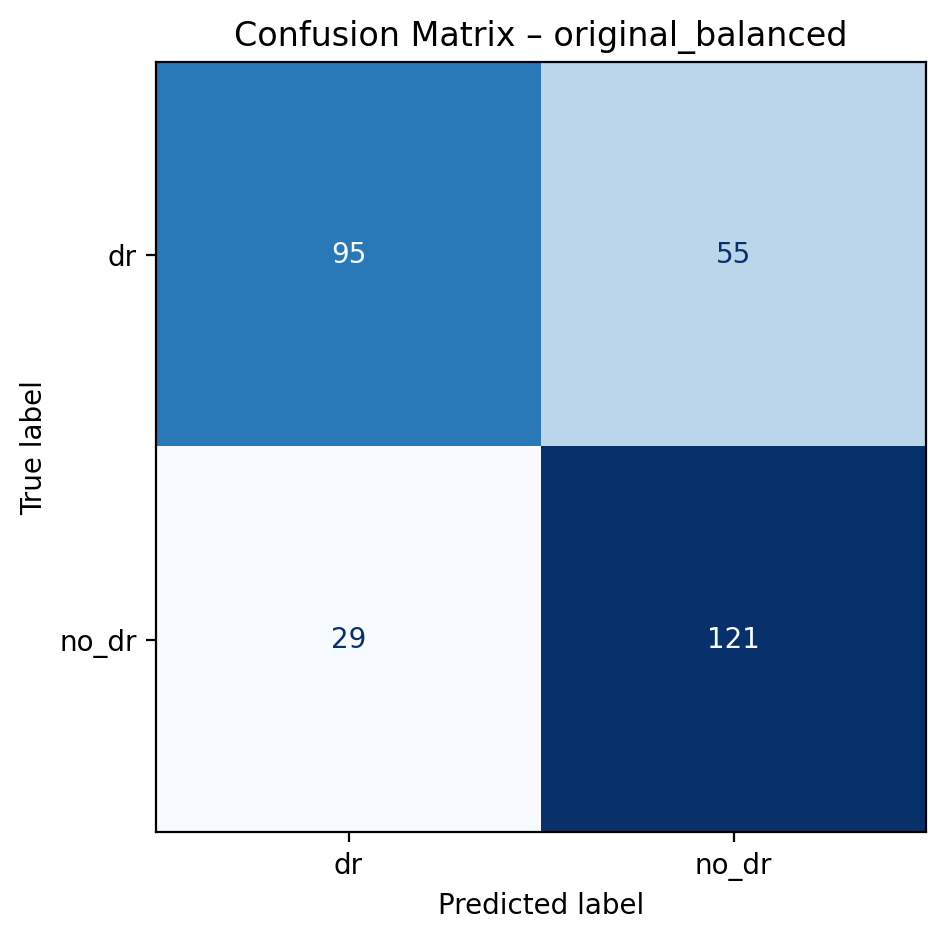

 CLIP finished original (balanced) in 0.2 min → acc=0.720, f1=0.718

 Running CLIP on degraded (balanced) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\1. Degraded_x2
 → Found 3662 images (excluding bicubic)


ZSL-clip-degraded_balanced: 100%|██████████| 300/300 [00:06<00:00, 44.04it/s]


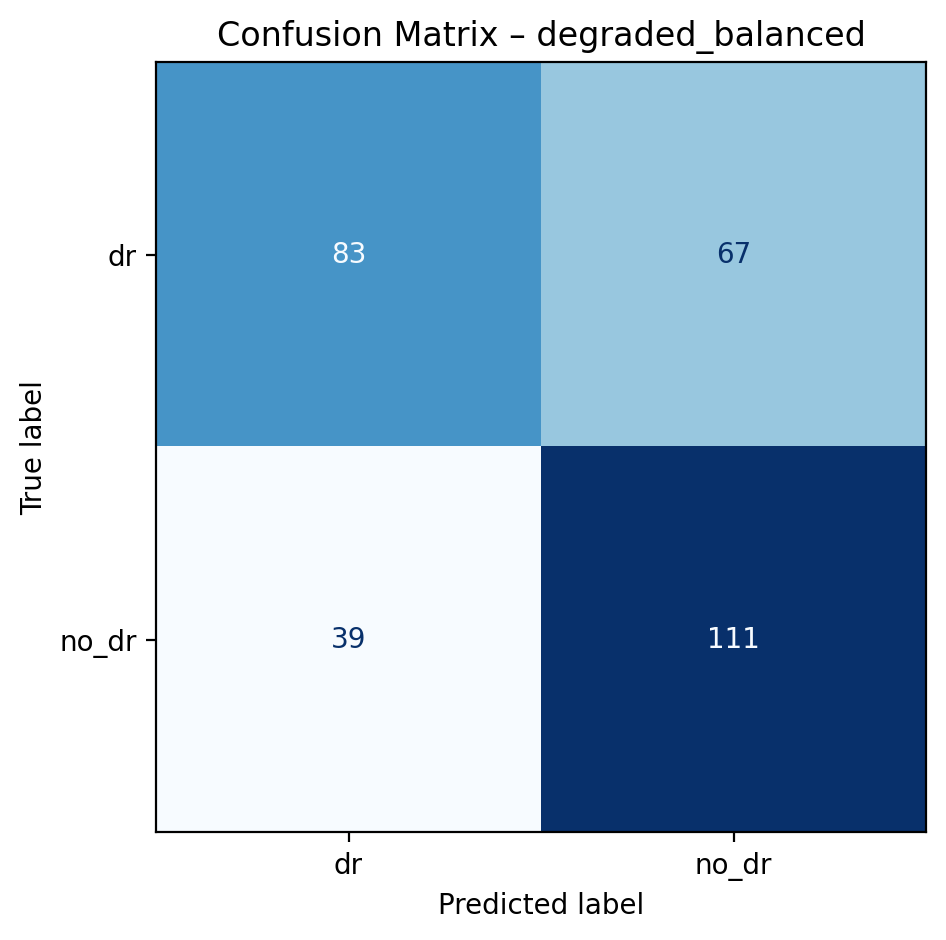

 CLIP finished degraded (balanced) in 0.1 min → acc=0.647, f1=0.644

 Running CLIP on espcn_SR_on_degraded (balanced) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\espcn\SR_on_degraded
 → Found 3662 images (excluding bicubic)


ZSL-clip-espcn_SR_on_degraded_balanced: 100%|██████████| 300/300 [00:07<00:00, 38.03it/s]


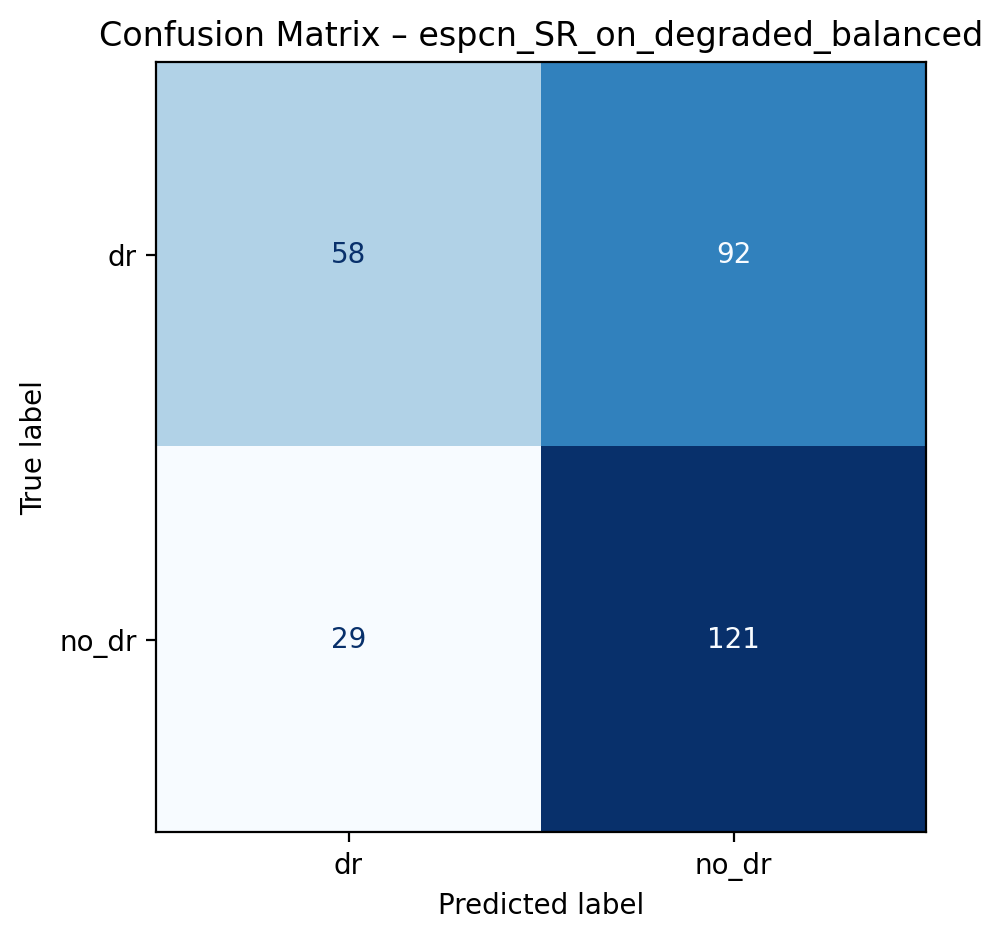

 CLIP finished espcn_SR_on_degraded (balanced) in 0.2 min → acc=0.597, f1=0.578

 Running CLIP on espcn_SR_on_original (balanced) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\espcn\SR_on_original
 → Found 3662 images (excluding bicubic)


ZSL-clip-espcn_SR_on_original_balanced: 100%|██████████| 300/300 [00:07<00:00, 38.33it/s]


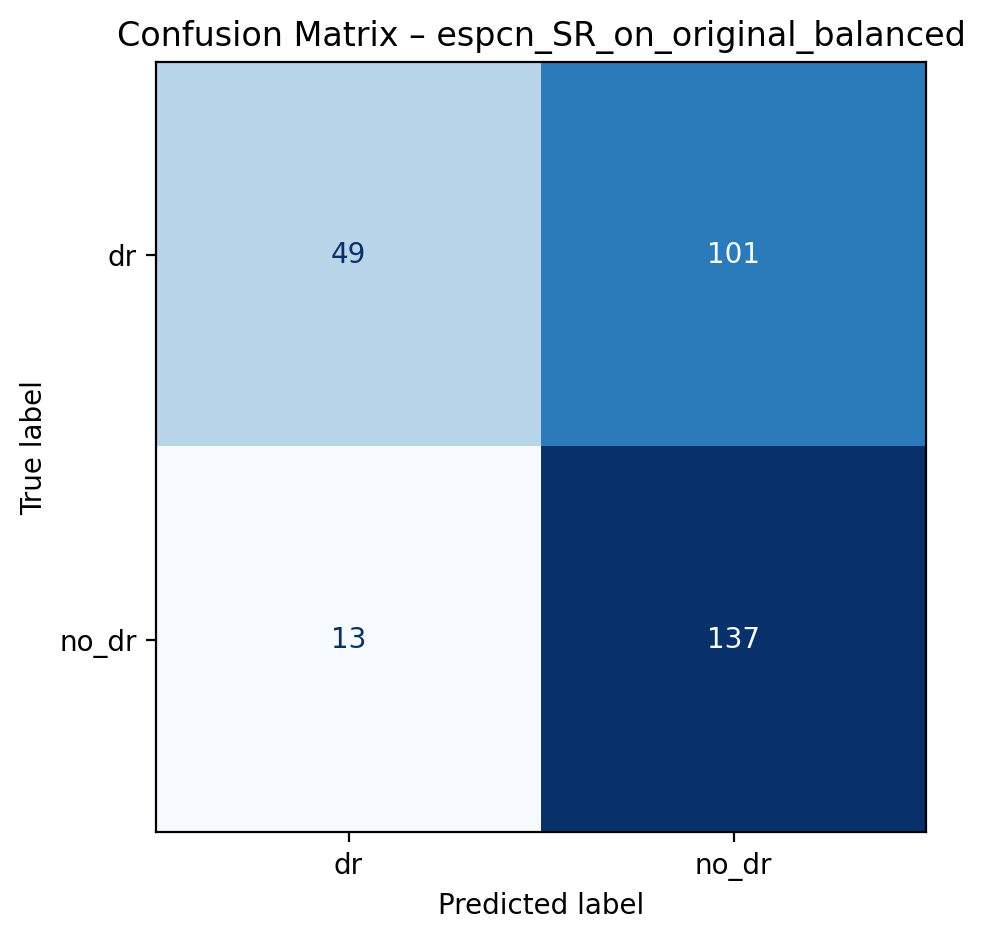

 CLIP finished espcn_SR_on_original (balanced) in 0.2 min → acc=0.620, f1=0.584

 Running CLIP on fsrcnn_SR_on_degraded (balanced) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\fsrcnn\SR_on_degraded
 → Found 3662 images (excluding bicubic)


ZSL-clip-fsrcnn_SR_on_degraded_balanced: 100%|██████████| 300/300 [00:07<00:00, 39.17it/s]


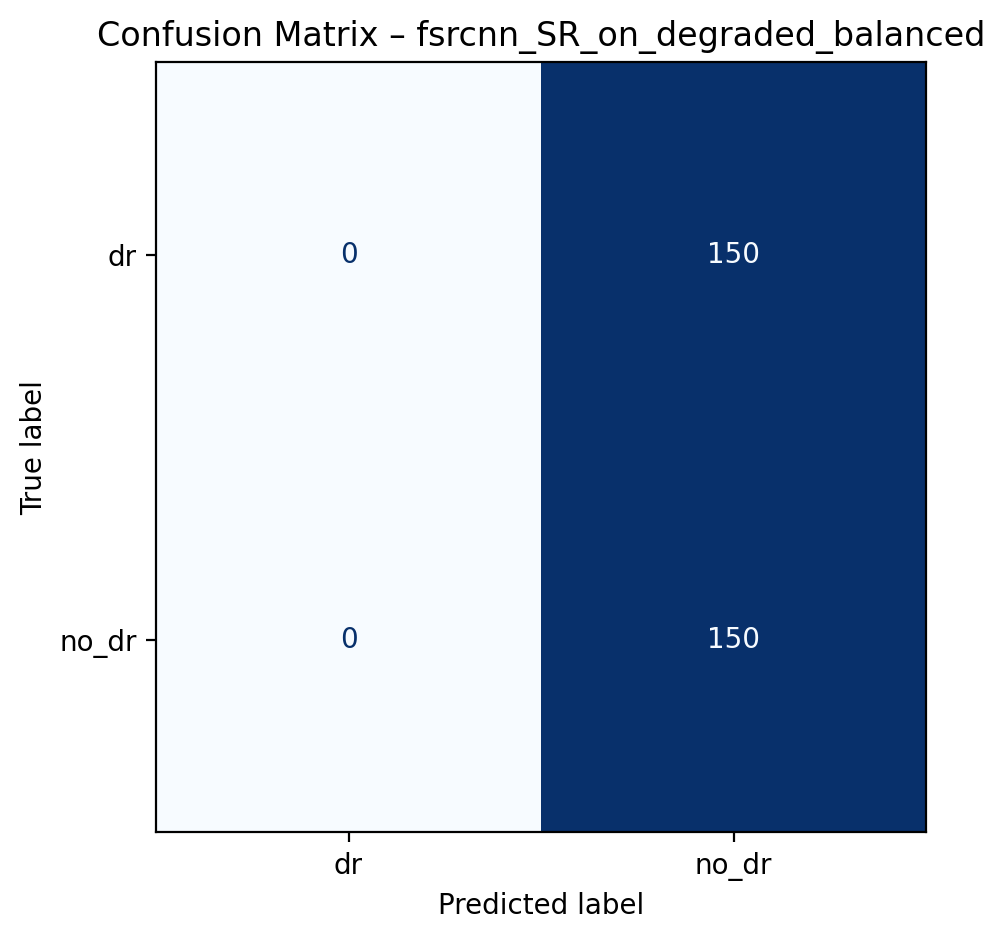

 CLIP finished fsrcnn_SR_on_degraded (balanced) in 0.2 min → acc=0.500, f1=0.333

 Running CLIP on fsrcnn_SR_on_original (balanced) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\fsrcnn\SR_on_original
 → Found 3662 images (excluding bicubic)


ZSL-clip-fsrcnn_SR_on_original_balanced: 100%|██████████| 300/300 [00:07<00:00, 39.00it/s]


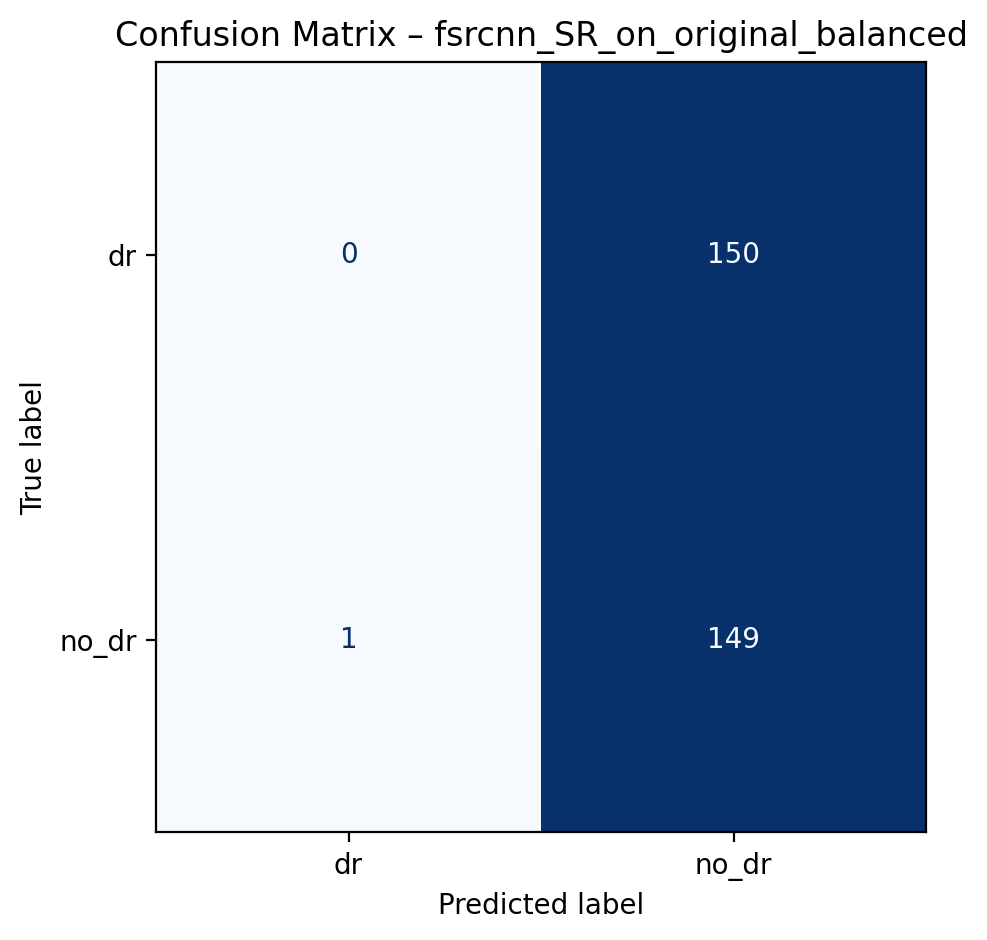

 CLIP finished fsrcnn_SR_on_original (balanced) in 0.2 min → acc=0.497, f1=0.332

 Running CLIP on srcnn_SR_on_degraded (balanced) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\srcnn\SR_on_degraded
 → Found 3662 images (excluding bicubic)


ZSL-clip-srcnn_SR_on_degraded_balanced: 100%|██████████| 300/300 [00:08<00:00, 36.62it/s]


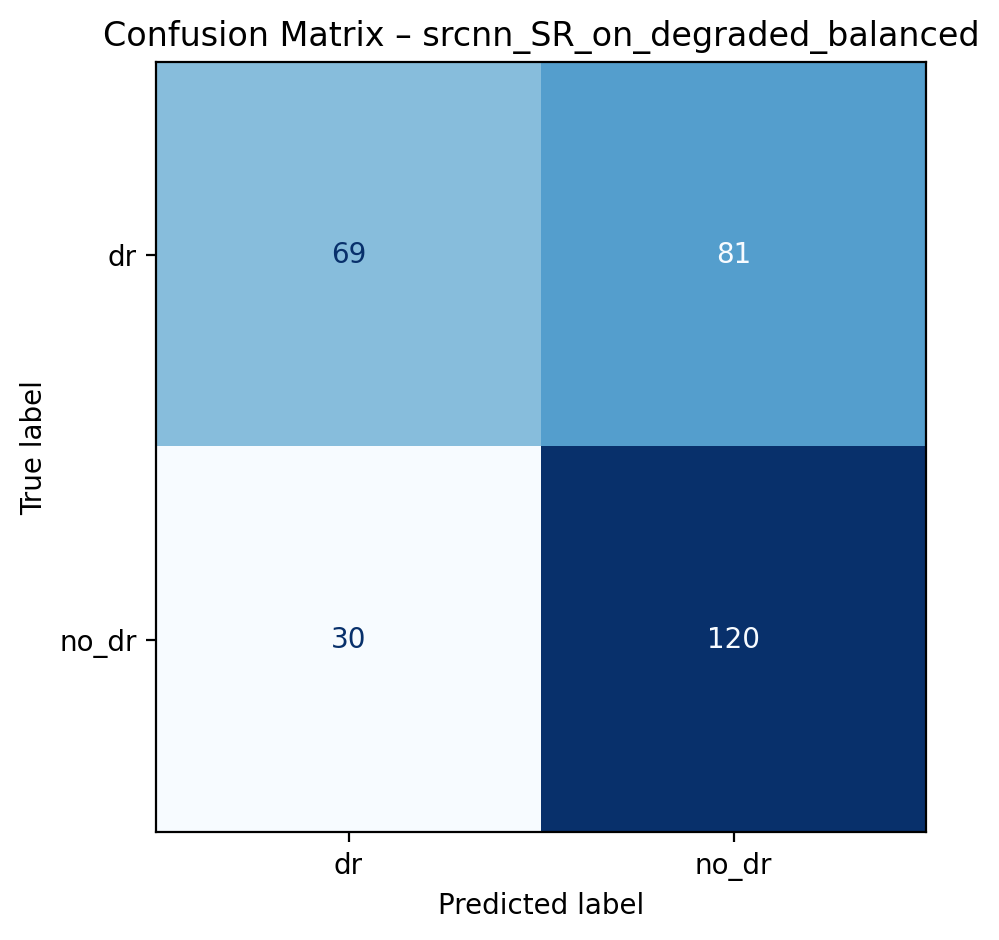

 CLIP finished srcnn_SR_on_degraded (balanced) in 0.2 min → acc=0.630, f1=0.619

 Running CLIP on srcnn_SR_on_original (balanced) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\srcnn\SR_on_original
 → Found 3662 images (excluding bicubic)


ZSL-clip-srcnn_SR_on_original_balanced: 100%|██████████| 300/300 [00:08<00:00, 37.38it/s]


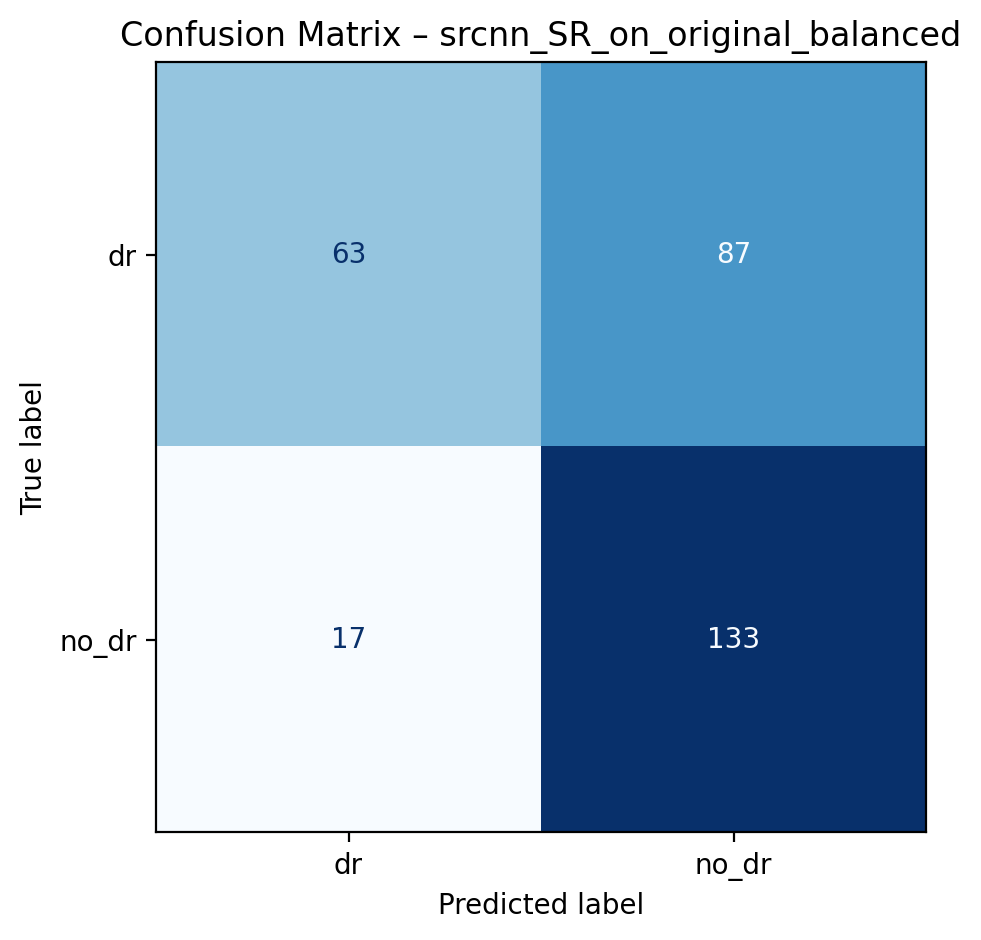

 CLIP finished srcnn_SR_on_original (balanced) in 0.2 min → acc=0.653, f1=0.633

========== RETCLIP ==========

 Running RETCLIP on original (balanced) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\train_ready_512
 → Found 3662 images (excluding bicubic)


ZSL-retclip-original_balanced: 100%|██████████| 300/300 [00:07<00:00, 42.48it/s]


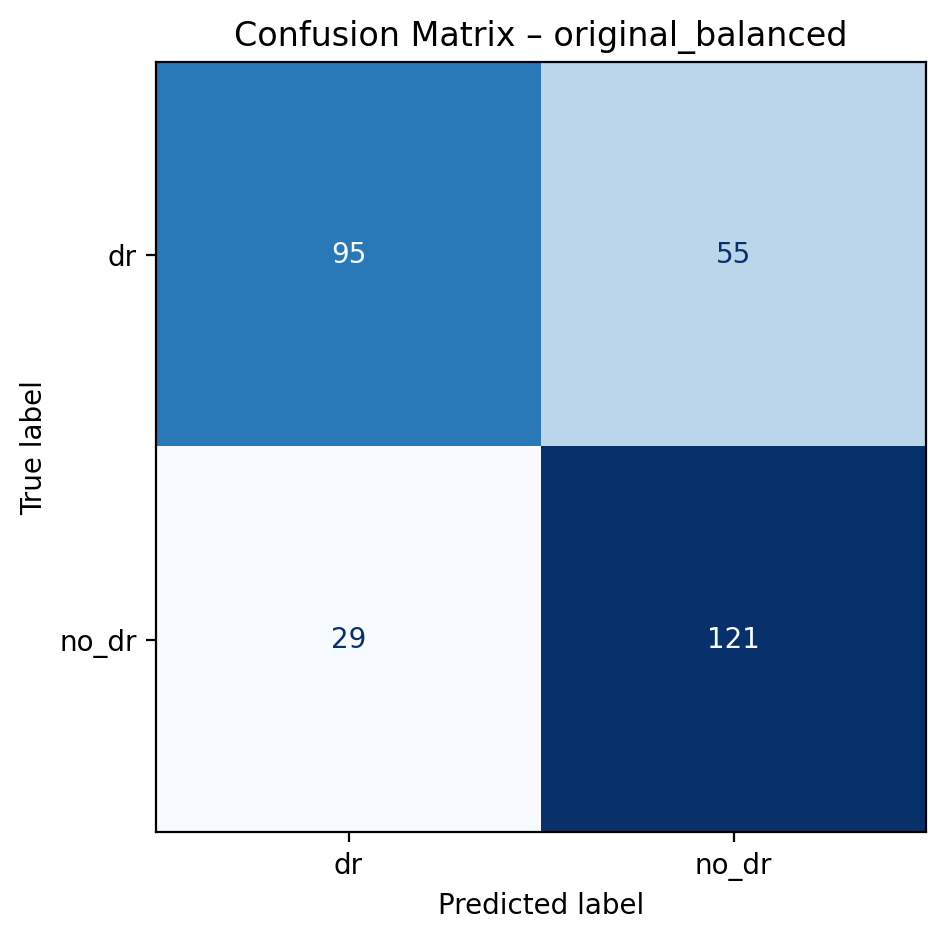

 RETCLIP finished original (balanced) in 0.1 min → acc=0.720, f1=0.718

 Running RETCLIP on degraded (balanced) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\1. Degraded_x2
 → Found 3662 images (excluding bicubic)


ZSL-retclip-degraded_balanced: 100%|██████████| 300/300 [00:06<00:00, 44.75it/s]


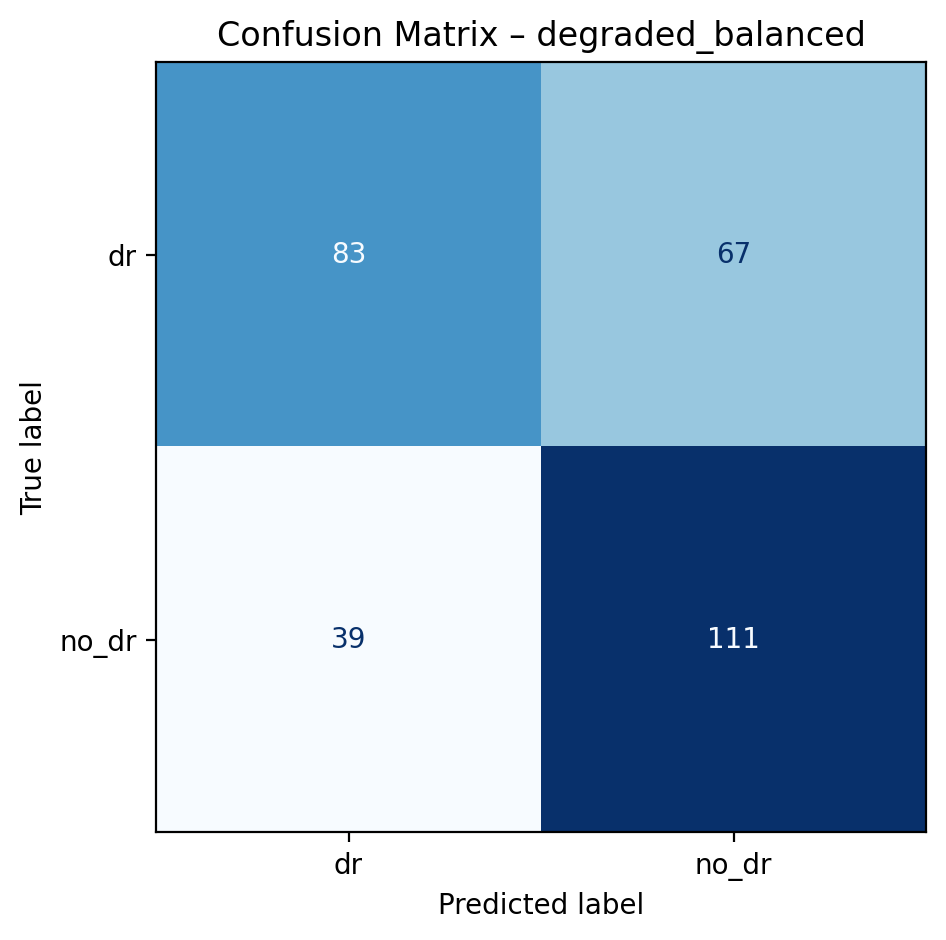

 RETCLIP finished degraded (balanced) in 0.1 min → acc=0.647, f1=0.644

 Running RETCLIP on espcn_SR_on_degraded (balanced) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\espcn\SR_on_degraded
 → Found 3662 images (excluding bicubic)


ZSL-retclip-espcn_SR_on_degraded_balanced: 100%|██████████| 300/300 [00:07<00:00, 41.95it/s]


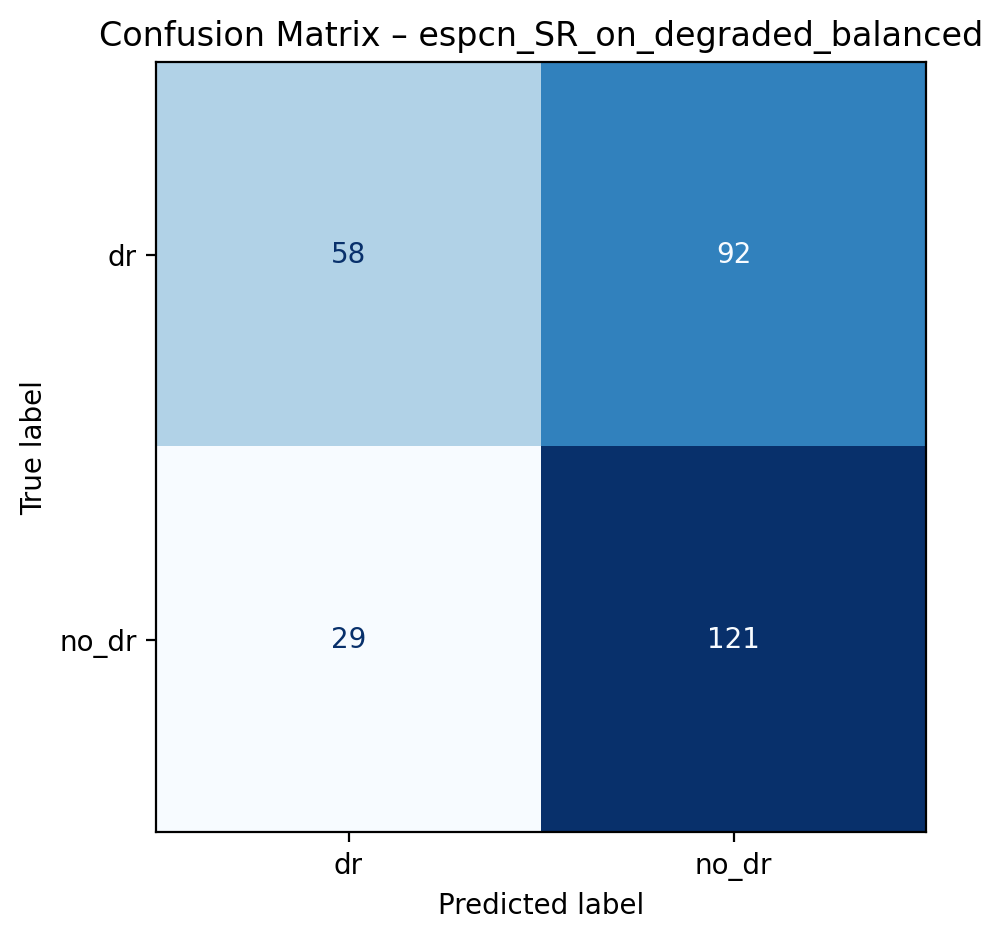

 RETCLIP finished espcn_SR_on_degraded (balanced) in 0.1 min → acc=0.597, f1=0.578

 Running RETCLIP on espcn_SR_on_original (balanced) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\espcn\SR_on_original
 → Found 3662 images (excluding bicubic)


ZSL-retclip-espcn_SR_on_original_balanced: 100%|██████████| 300/300 [00:07<00:00, 42.42it/s]


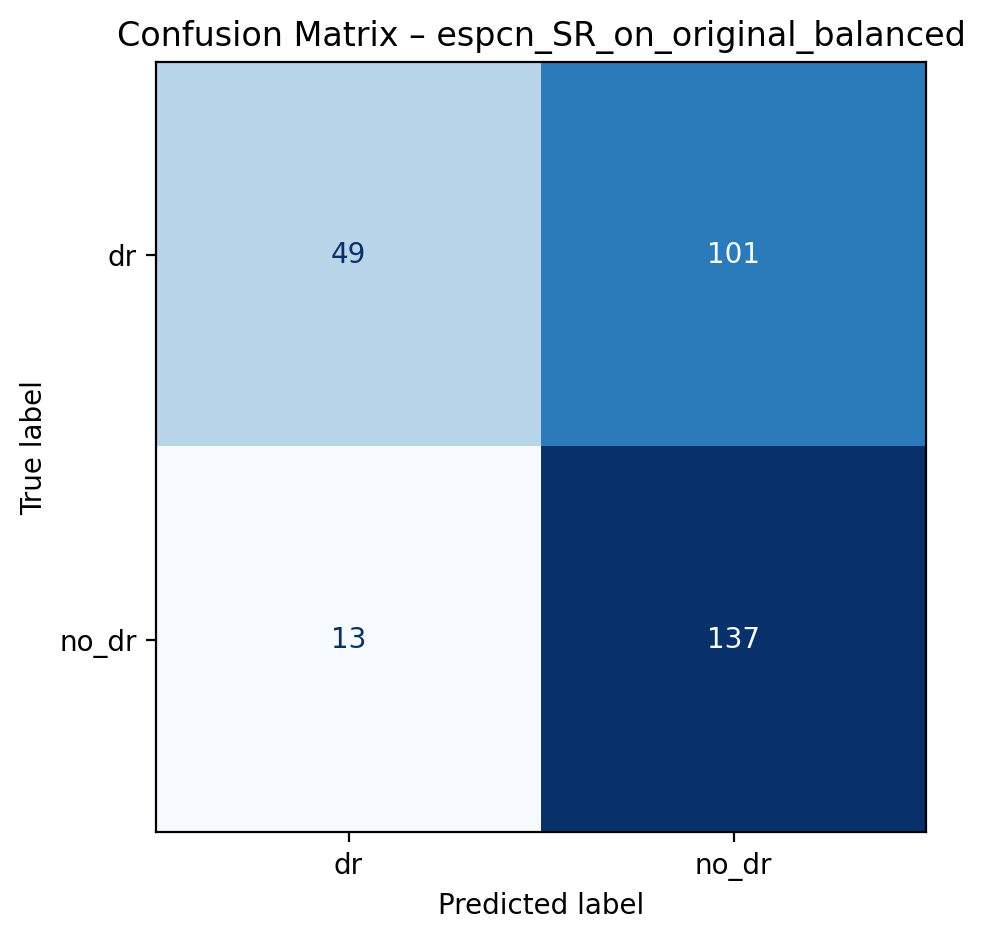

 RETCLIP finished espcn_SR_on_original (balanced) in 0.1 min → acc=0.620, f1=0.584

 Running RETCLIP on fsrcnn_SR_on_degraded (balanced) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\fsrcnn\SR_on_degraded
 → Found 3662 images (excluding bicubic)


ZSL-retclip-fsrcnn_SR_on_degraded_balanced: 100%|██████████| 300/300 [00:06<00:00, 43.50it/s]


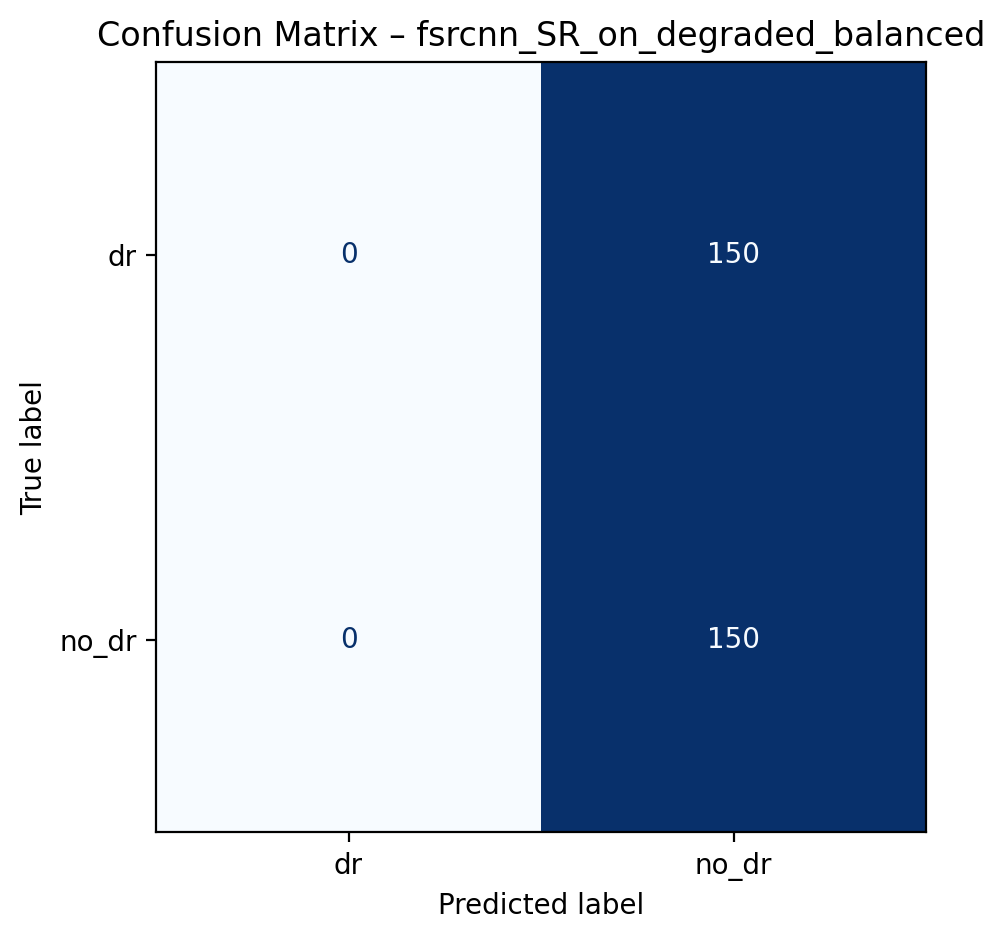

 RETCLIP finished fsrcnn_SR_on_degraded (balanced) in 0.1 min → acc=0.500, f1=0.333

 Running RETCLIP on fsrcnn_SR_on_original (balanced) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\fsrcnn\SR_on_original
 → Found 3662 images (excluding bicubic)


ZSL-retclip-fsrcnn_SR_on_original_balanced: 100%|██████████| 300/300 [00:06<00:00, 43.57it/s]


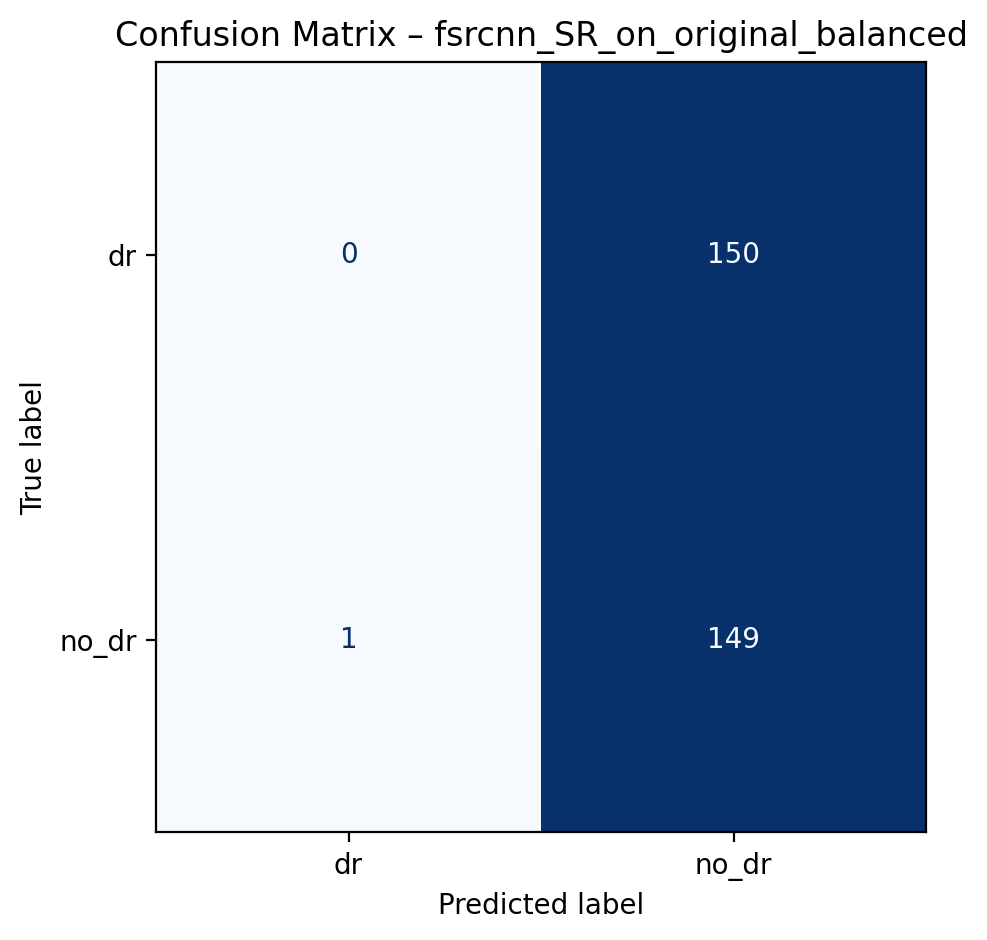

 RETCLIP finished fsrcnn_SR_on_original (balanced) in 0.1 min → acc=0.497, f1=0.332

 Running RETCLIP on srcnn_SR_on_degraded (balanced) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\srcnn\SR_on_degraded
 → Found 3662 images (excluding bicubic)


ZSL-retclip-srcnn_SR_on_degraded_balanced: 100%|██████████| 300/300 [00:07<00:00, 40.79it/s]


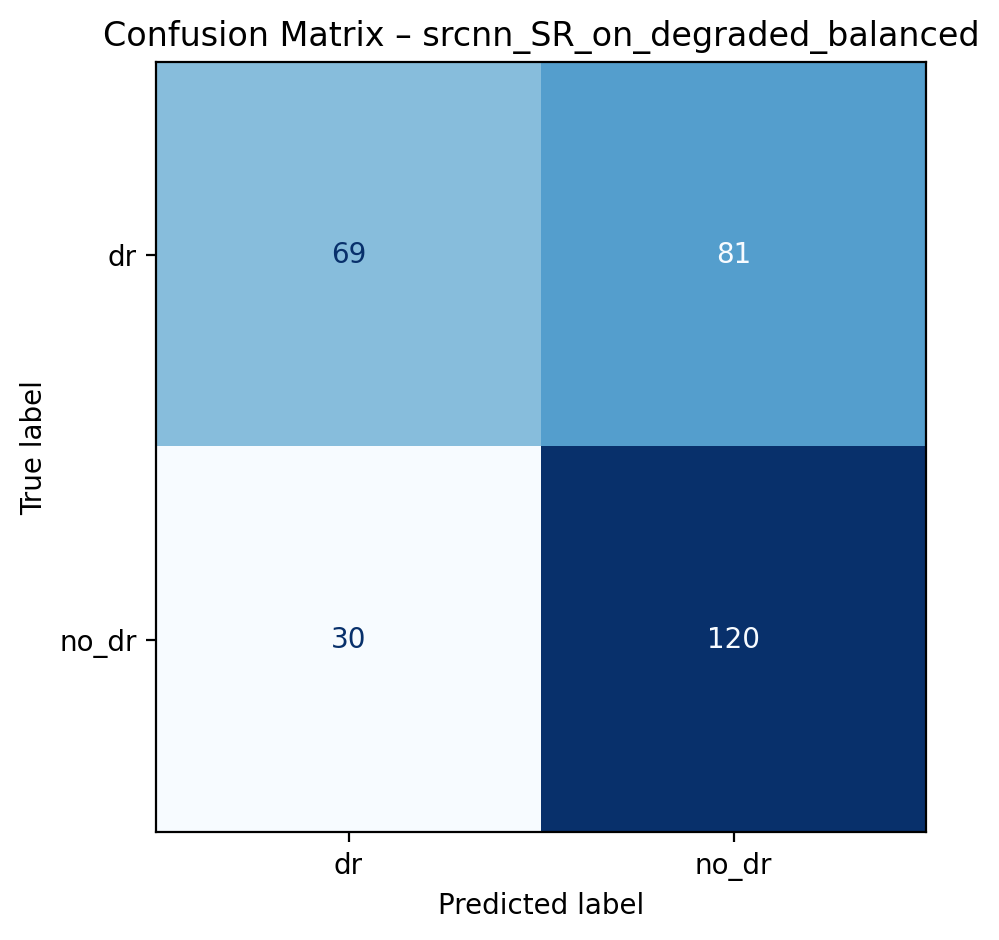

 RETCLIP finished srcnn_SR_on_degraded (balanced) in 0.2 min → acc=0.630, f1=0.619

 Running RETCLIP on srcnn_SR_on_original (balanced) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\srcnn\SR_on_original
 → Found 3662 images (excluding bicubic)


ZSL-retclip-srcnn_SR_on_original_balanced: 100%|██████████| 300/300 [00:07<00:00, 41.32it/s]


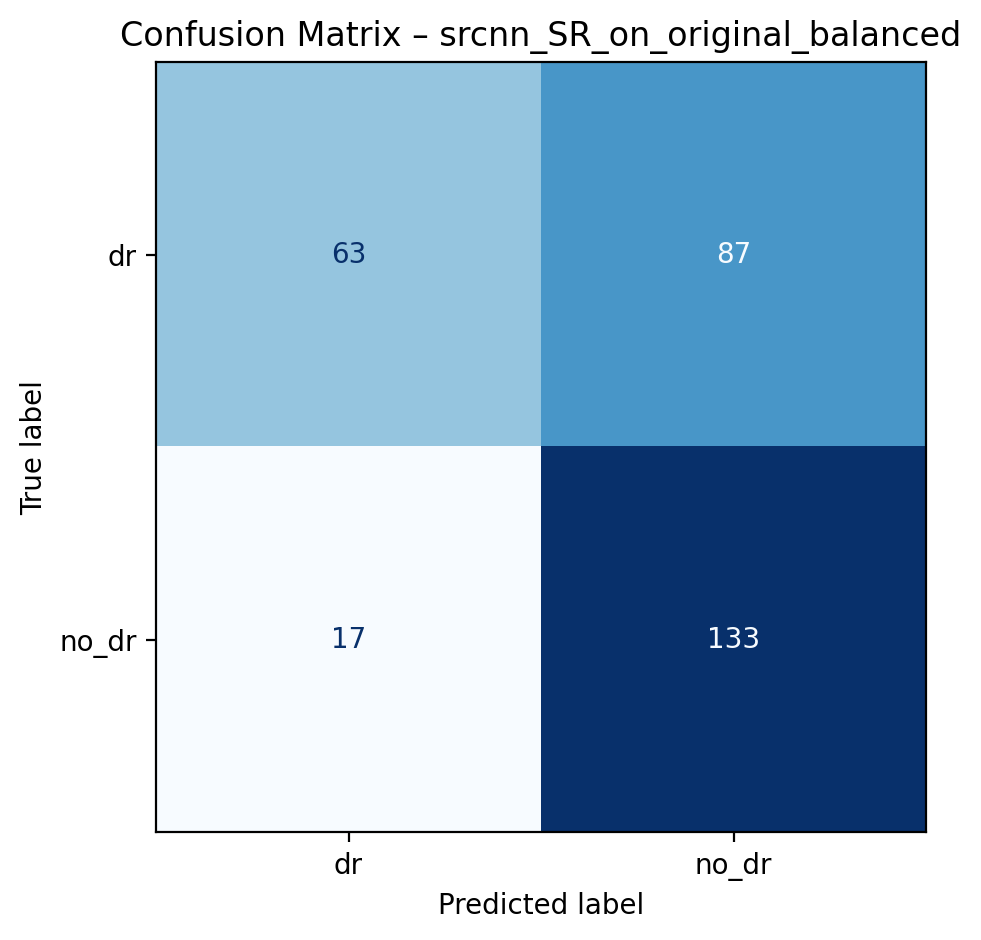

 RETCLIP finished srcnn_SR_on_original (balanced) in 0.1 min → acc=0.653, f1=0.633

=== BENCHMARK (balanced) COMPLETE (02:35:25) ===
   backbone              condition      mode       acc        f1  \
0      clip               original  balanced  0.720000  0.717881   
1      clip               degraded  balanced  0.646667  0.643562   
2      clip   espcn_SR_on_degraded  balanced  0.596667  0.578059   
3      clip   espcn_SR_on_original  balanced  0.620000  0.584225   
4      clip  fsrcnn_SR_on_degraded  balanced  0.500000  0.333333   
5      clip  fsrcnn_SR_on_original  balanced  0.496667  0.331849   
6      clip   srcnn_SR_on_degraded  balanced  0.630000  0.618989   
7      clip   srcnn_SR_on_original  balanced  0.653333  0.633373   
8   retclip               original  balanced  0.720000  0.717881   
9   retclip               degraded  balanced  0.646667  0.643562   
10  retclip   espcn_SR_on_degraded  balanced  0.596667  0.578059   
11  retclip   espcn_SR_on_original  balanced  0.620

ZSL-clip-original_full: 100%|██████████| 3662/3662 [01:28<00:00, 41.38it/s]


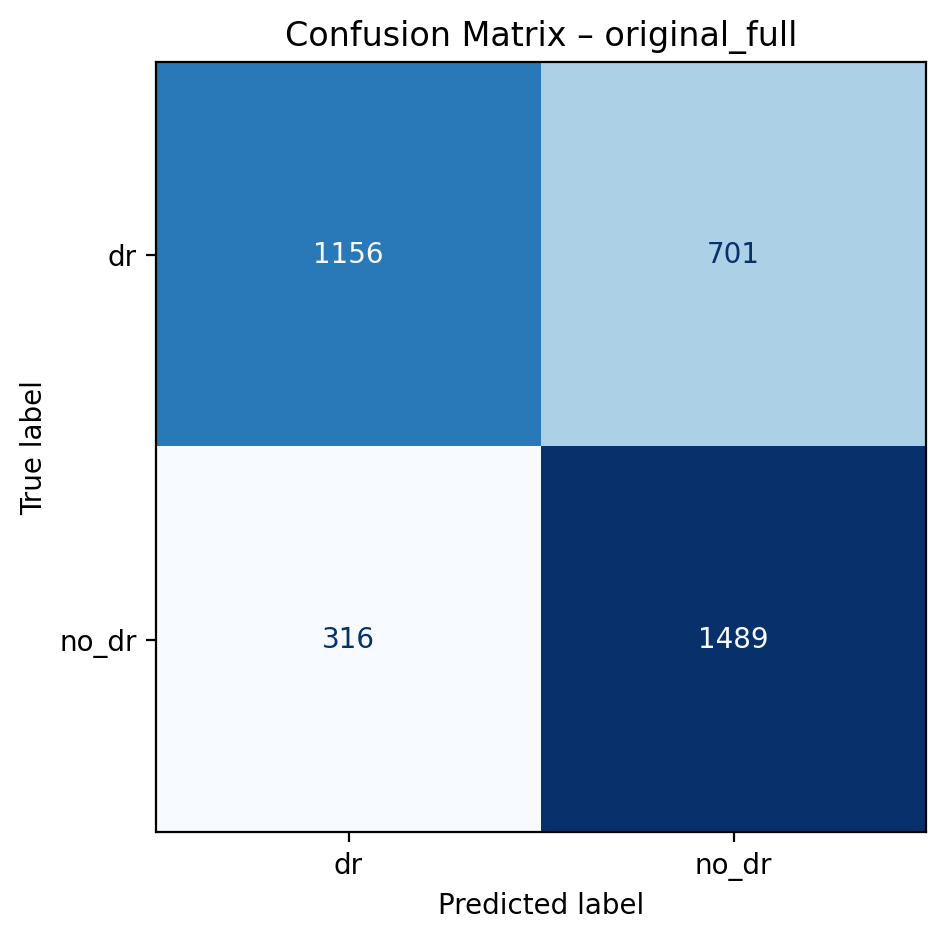

 CLIP finished original (full) in 1.5 min → acc=0.722, f1=0.720

 Running CLIP on degraded (full) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\1. Degraded_x2
 → Found 3662 images (excluding bicubic)


ZSL-clip-degraded_full: 100%|██████████| 3662/3662 [01:23<00:00, 44.12it/s]


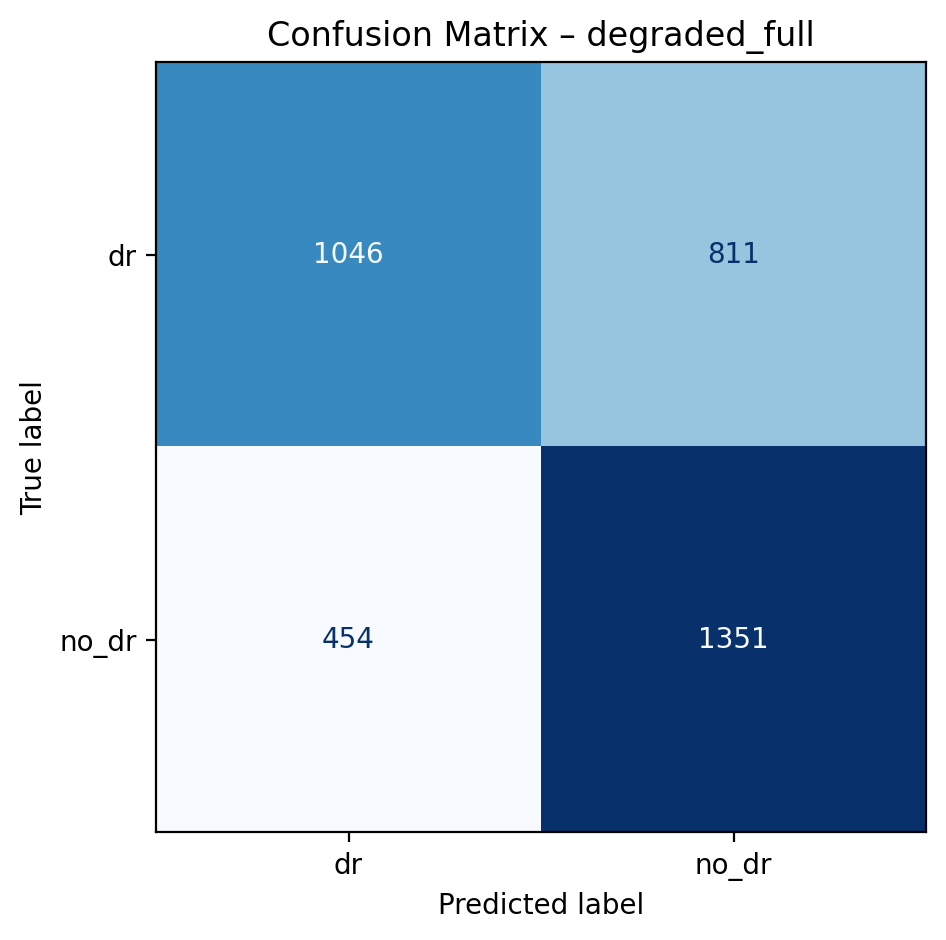

 CLIP finished degraded (full) in 1.4 min → acc=0.655, f1=0.652

 Running CLIP on espcn_SR_on_degraded (full) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\espcn\SR_on_degraded
 → Found 3662 images (excluding bicubic)


ZSL-clip-espcn_SR_on_degraded_full: 100%|██████████| 3662/3662 [01:56<00:00, 31.47it/s]


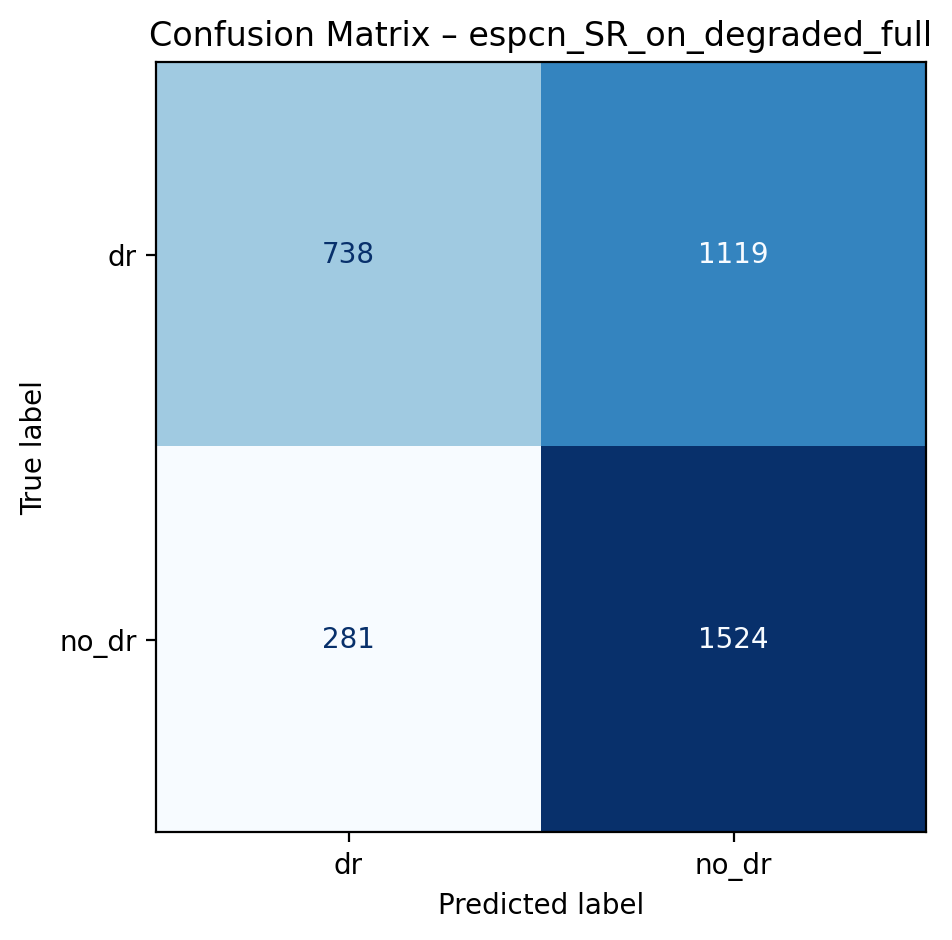

 CLIP finished espcn_SR_on_degraded (full) in 2.0 min → acc=0.618, f1=0.599

 Running CLIP on espcn_SR_on_original (full) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\espcn\SR_on_original
 → Found 3662 images (excluding bicubic)


ZSL-clip-espcn_SR_on_original_full: 100%|██████████| 3662/3662 [01:53<00:00, 32.20it/s]


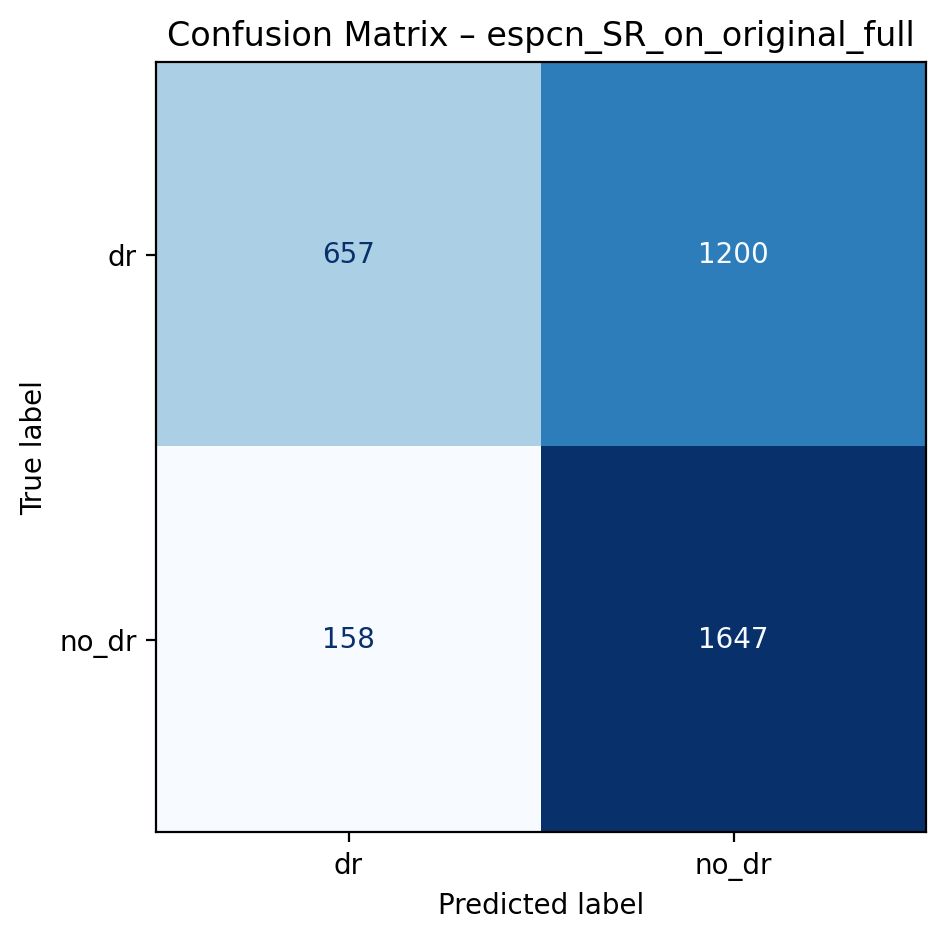

 CLIP finished espcn_SR_on_original (full) in 1.9 min → acc=0.629, f1=0.600

 Running CLIP on fsrcnn_SR_on_degraded (full) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\fsrcnn\SR_on_degraded
 → Found 3662 images (excluding bicubic)


ZSL-clip-fsrcnn_SR_on_degraded_full: 100%|██████████| 3662/3662 [01:53<00:00, 32.19it/s]


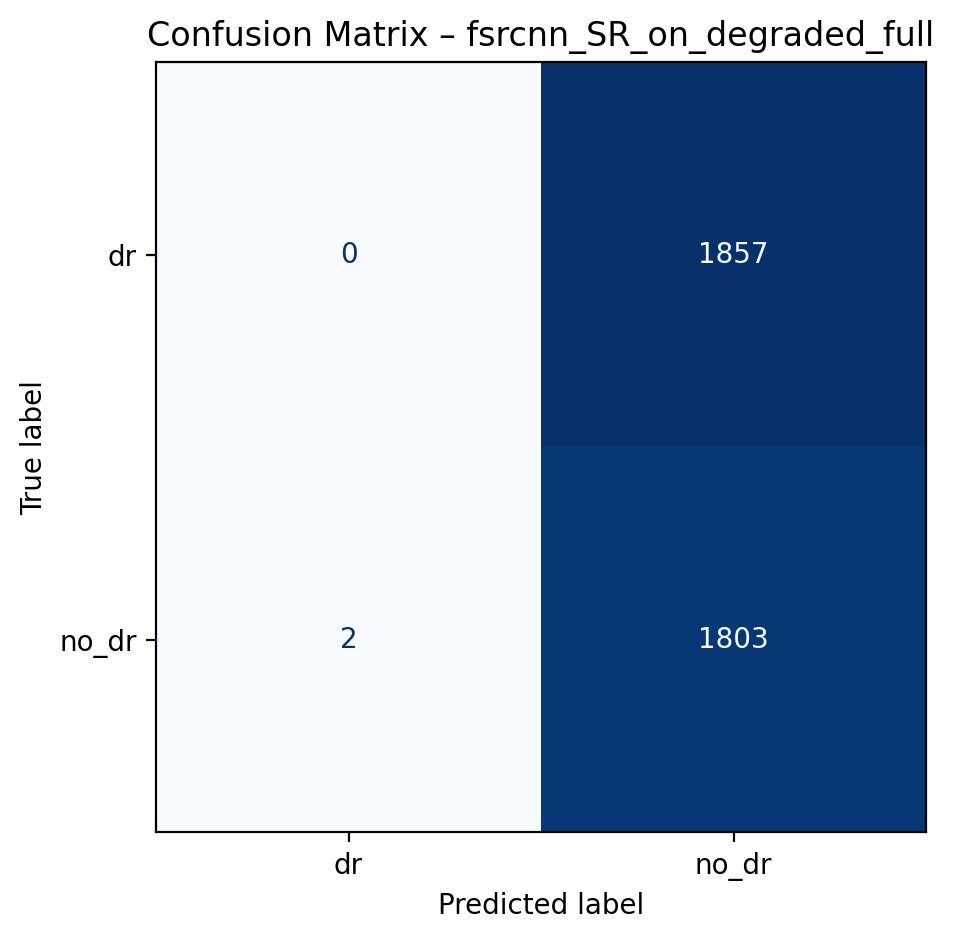

 CLIP finished fsrcnn_SR_on_degraded (full) in 1.9 min → acc=0.492, f1=0.330

 Running CLIP on fsrcnn_SR_on_original (full) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\fsrcnn\SR_on_original
 → Found 3662 images (excluding bicubic)


ZSL-clip-fsrcnn_SR_on_original_full: 100%|██████████| 3662/3662 [01:51<00:00, 32.86it/s]


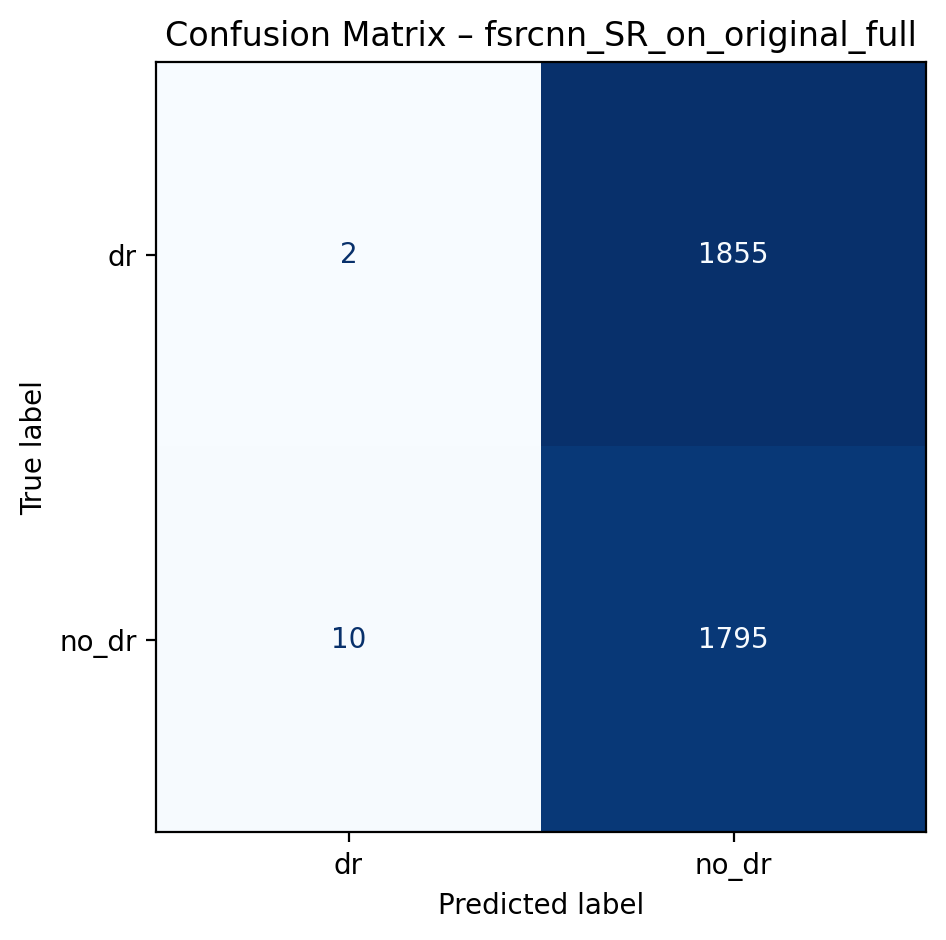

 CLIP finished fsrcnn_SR_on_original (full) in 1.9 min → acc=0.491, f1=0.330

 Running CLIP on srcnn_SR_on_degraded (full) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\srcnn\SR_on_degraded
 → Found 3662 images (excluding bicubic)


ZSL-clip-srcnn_SR_on_degraded_full: 100%|██████████| 3662/3662 [01:55<00:00, 31.67it/s]


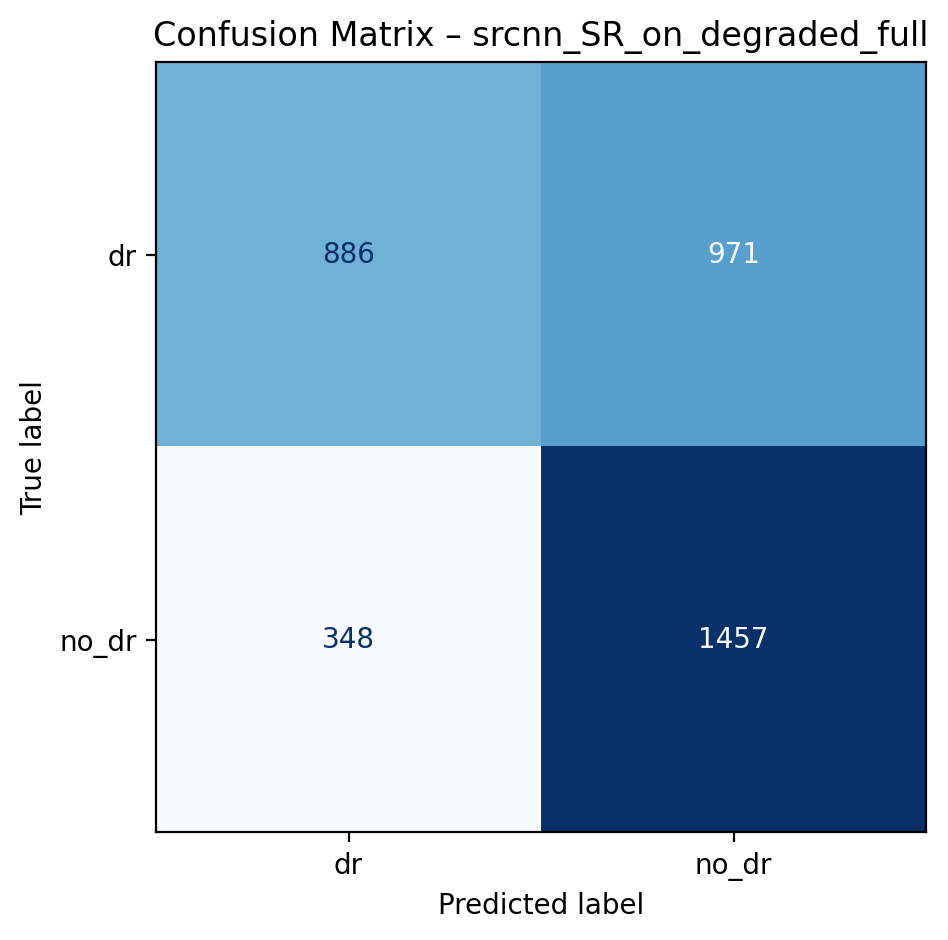

 CLIP finished srcnn_SR_on_degraded (full) in 2.0 min → acc=0.640, f1=0.631

 Running CLIP on srcnn_SR_on_original (full) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\srcnn\SR_on_original
 → Found 3662 images (excluding bicubic)


ZSL-clip-srcnn_SR_on_original_full: 100%|██████████| 3662/3662 [01:56<00:00, 31.35it/s]


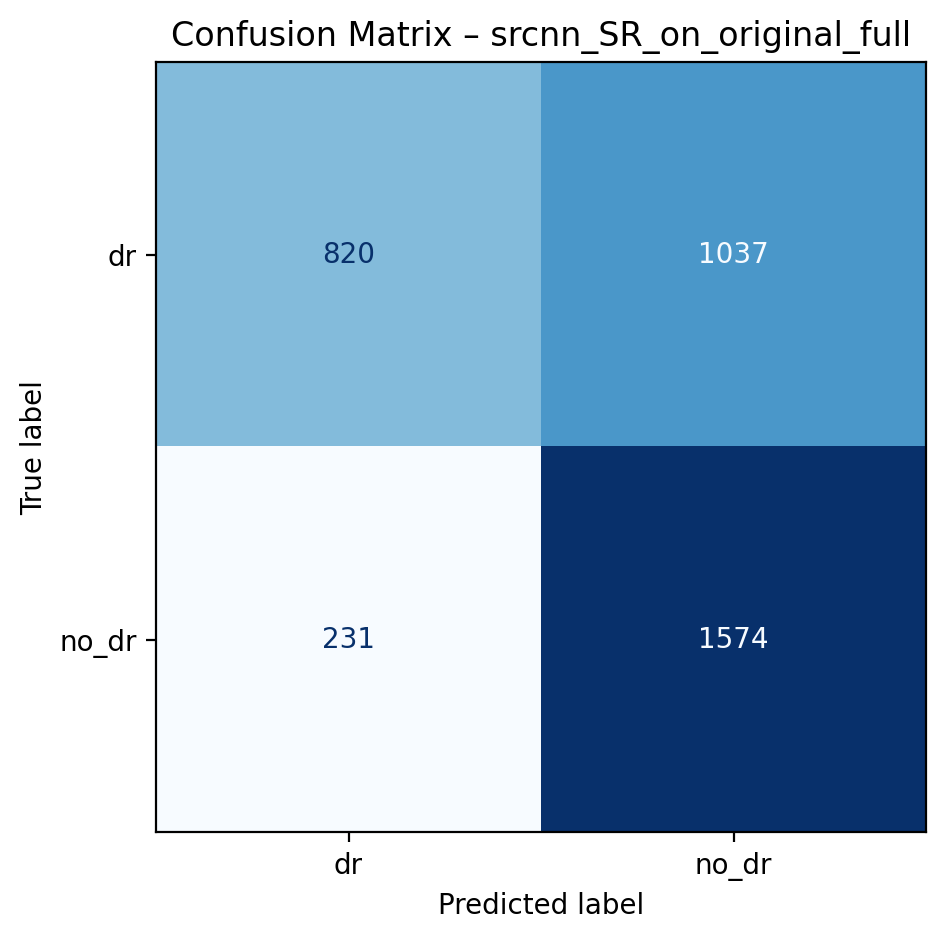

 CLIP finished srcnn_SR_on_original (full) in 2.0 min → acc=0.654, f1=0.638

========== RETCLIP ==========

 Running RETCLIP on original (full) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\train_ready_512
 → Found 3662 images (excluding bicubic)


ZSL-retclip-original_full: 100%|██████████| 3662/3662 [01:29<00:00, 40.95it/s]


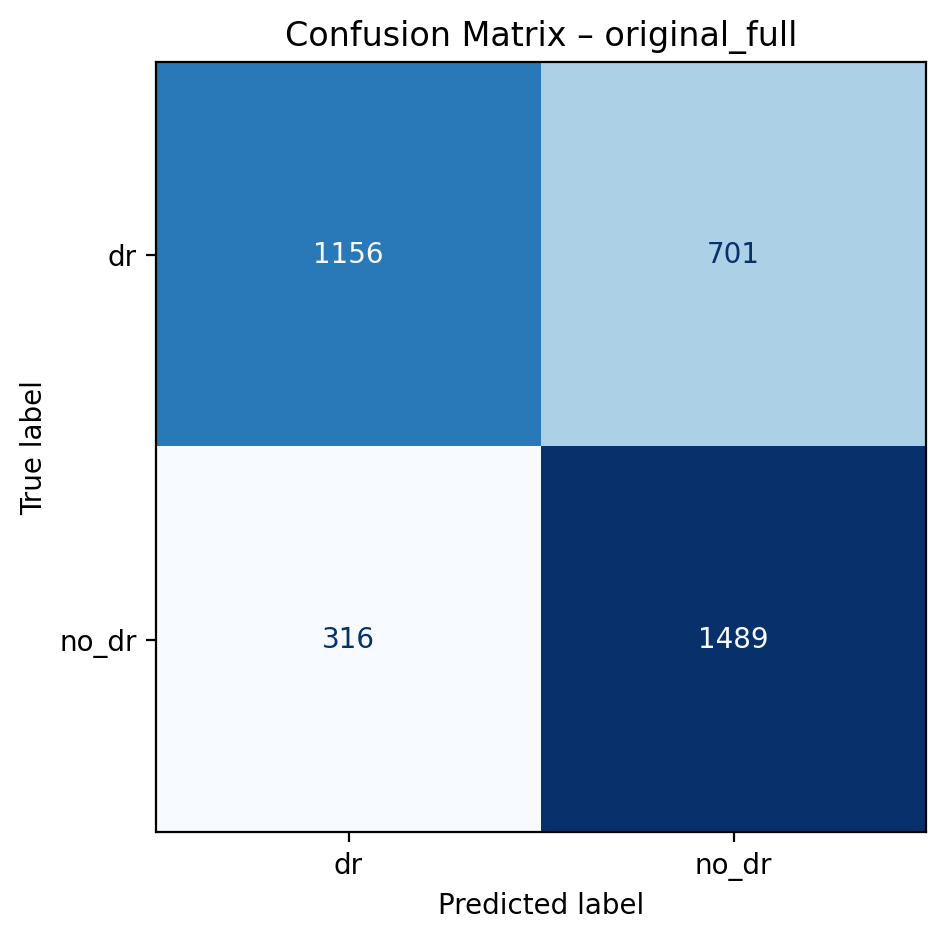

 RETCLIP finished original (full) in 1.5 min → acc=0.722, f1=0.720

 Running RETCLIP on degraded (full) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\1. Degraded_x2
 → Found 3662 images (excluding bicubic)


ZSL-retclip-degraded_full: 100%|██████████| 3662/3662 [01:23<00:00, 43.65it/s]


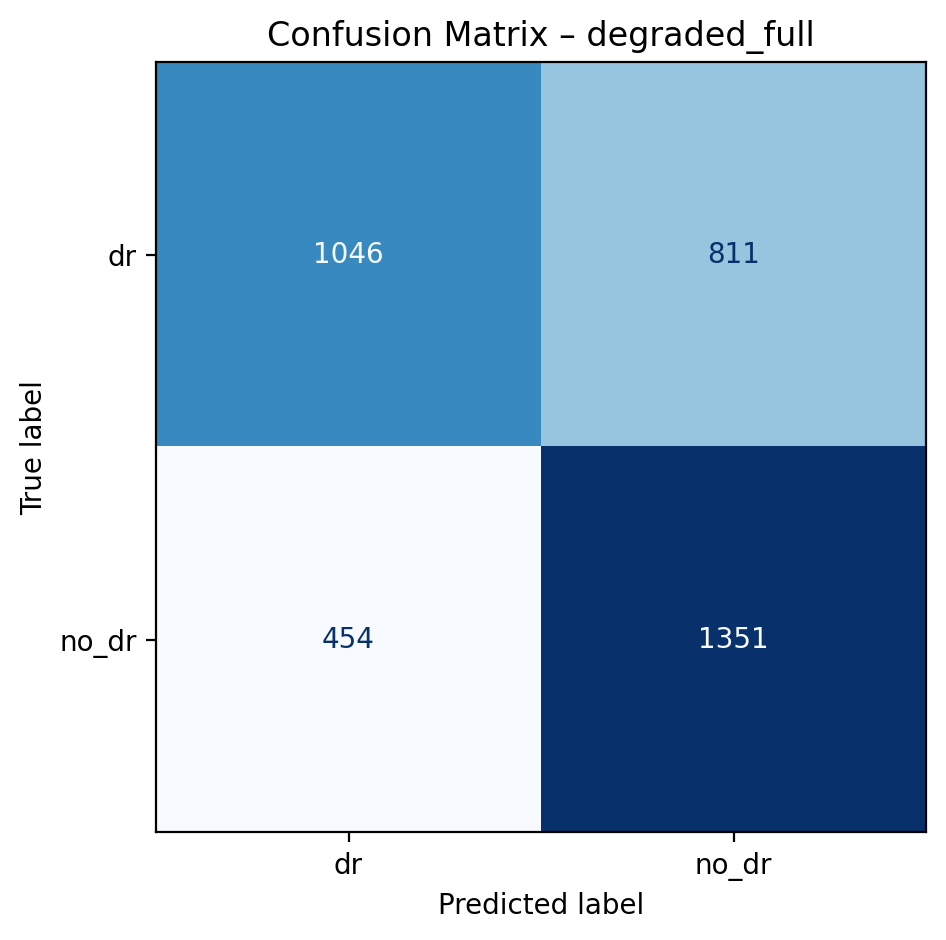

 RETCLIP finished degraded (full) in 1.4 min → acc=0.655, f1=0.652

 Running RETCLIP on espcn_SR_on_degraded (full) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\espcn\SR_on_degraded
 → Found 3662 images (excluding bicubic)


ZSL-retclip-espcn_SR_on_degraded_full: 100%|██████████| 3662/3662 [01:33<00:00, 39.01it/s]


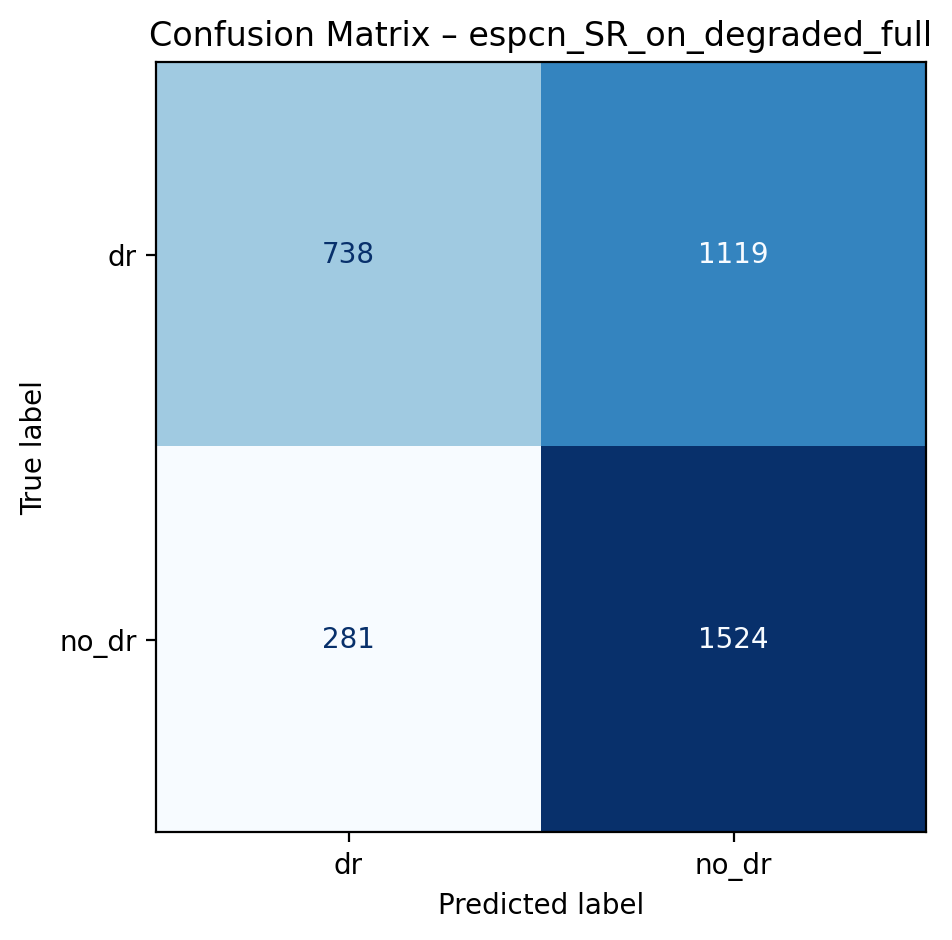

 RETCLIP finished espcn_SR_on_degraded (full) in 1.6 min → acc=0.618, f1=0.599

 Running RETCLIP on espcn_SR_on_original (full) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\espcn\SR_on_original
 → Found 3662 images (excluding bicubic)


ZSL-retclip-espcn_SR_on_original_full: 100%|██████████| 3662/3662 [01:35<00:00, 38.54it/s]


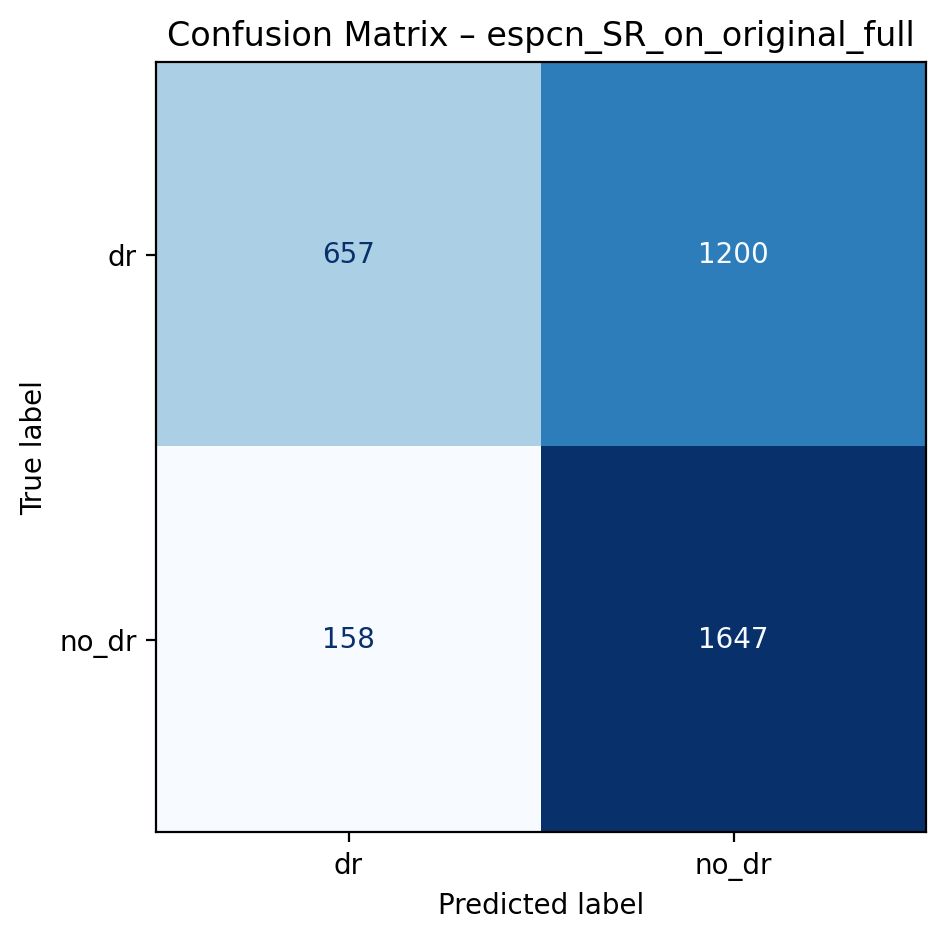

 RETCLIP finished espcn_SR_on_original (full) in 1.6 min → acc=0.629, f1=0.600

 Running RETCLIP on fsrcnn_SR_on_degraded (full) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\fsrcnn\SR_on_degraded
 → Found 3662 images (excluding bicubic)


ZSL-retclip-fsrcnn_SR_on_degraded_full: 100%|██████████| 3662/3662 [01:29<00:00, 41.06it/s]


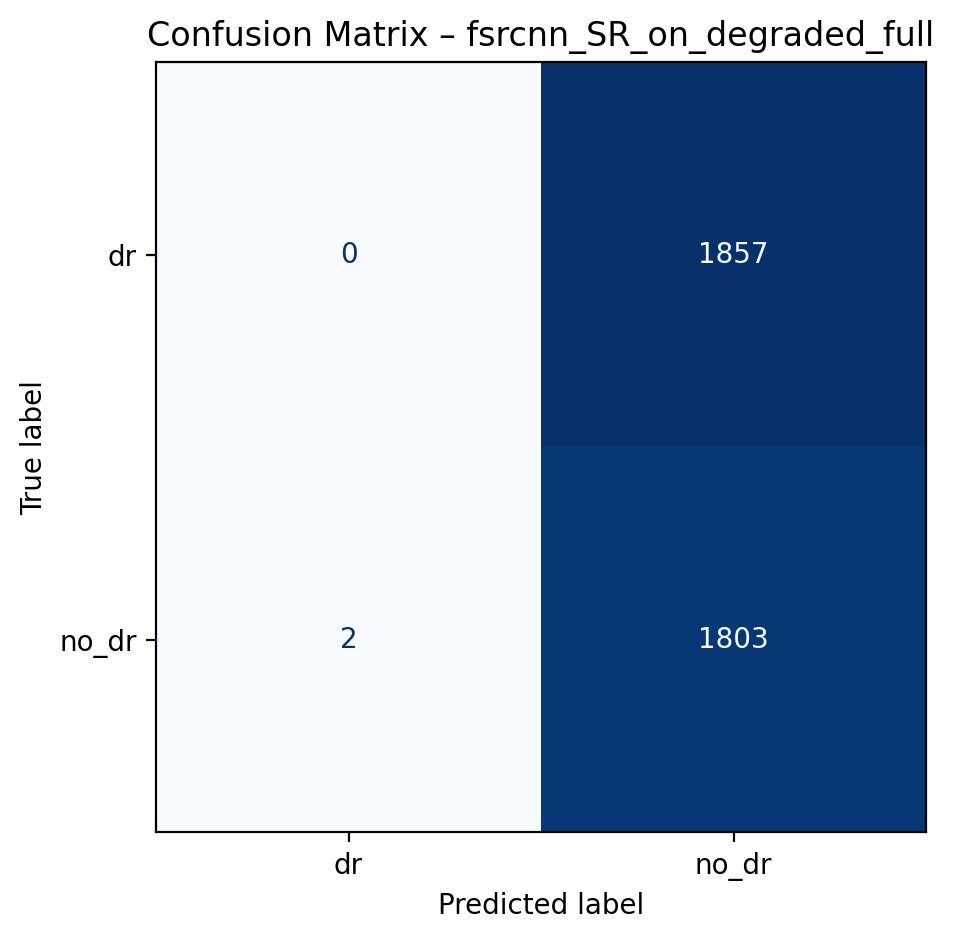

 RETCLIP finished fsrcnn_SR_on_degraded (full) in 1.5 min → acc=0.492, f1=0.330

 Running RETCLIP on fsrcnn_SR_on_original (full) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\fsrcnn\SR_on_original
 → Found 3662 images (excluding bicubic)


ZSL-retclip-fsrcnn_SR_on_original_full: 100%|██████████| 3662/3662 [01:29<00:00, 41.08it/s]


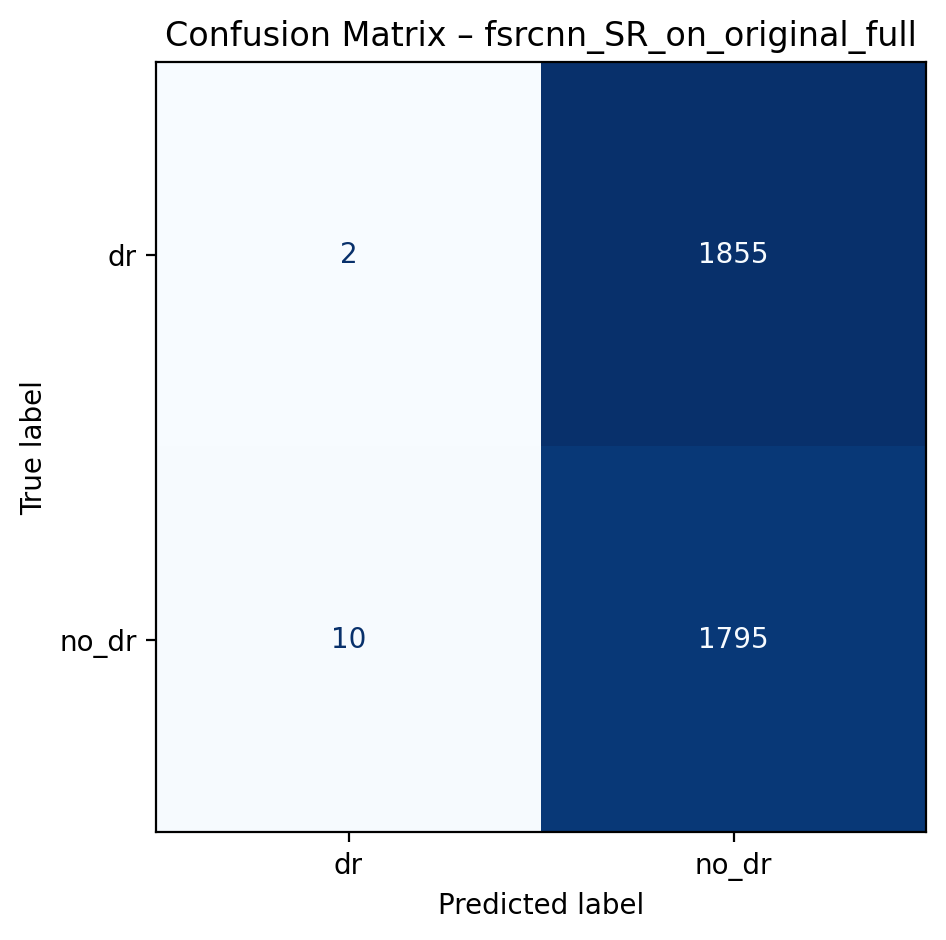

 RETCLIP finished fsrcnn_SR_on_original (full) in 1.5 min → acc=0.491, f1=0.330

 Running RETCLIP on srcnn_SR_on_degraded (full) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\srcnn\SR_on_degraded
 → Found 3662 images (excluding bicubic)


ZSL-retclip-srcnn_SR_on_degraded_full: 100%|██████████| 3662/3662 [01:33<00:00, 39.02it/s]


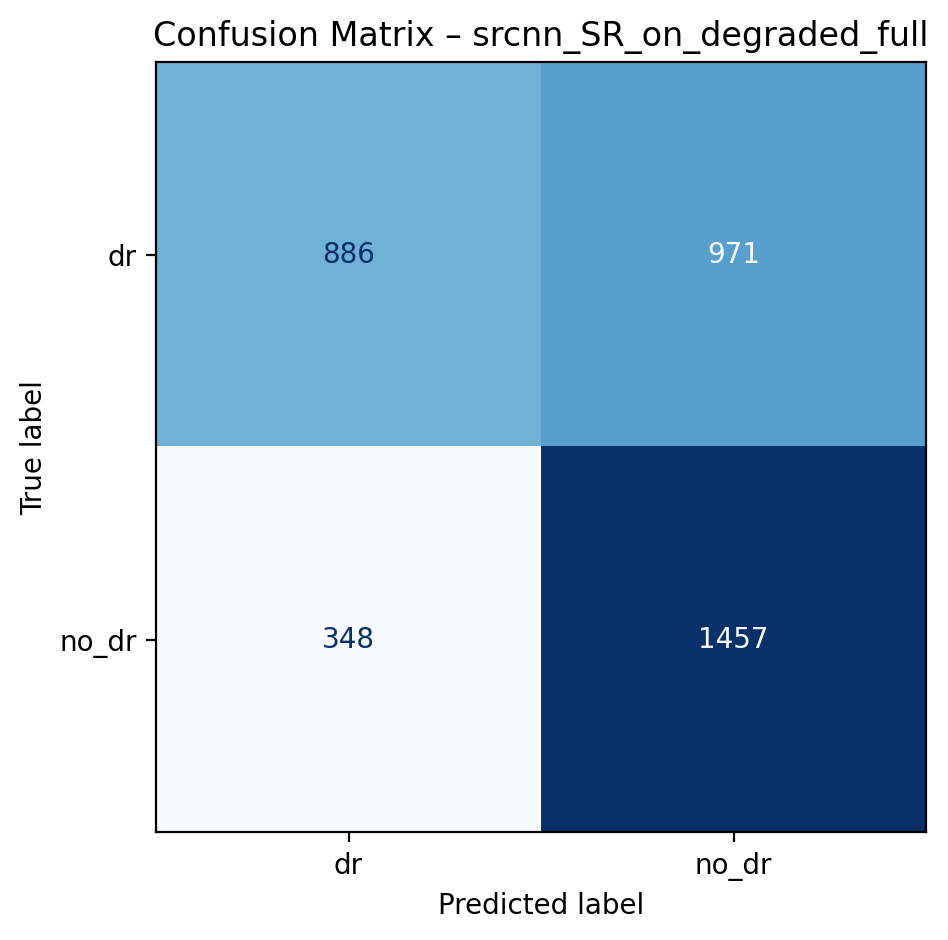

 RETCLIP finished srcnn_SR_on_degraded (full) in 1.6 min → acc=0.640, f1=0.631

 Running RETCLIP on srcnn_SR_on_original (full) …
[ZSL] Searching under C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\srcnn\SR_on_original
 → Found 3662 images (excluding bicubic)


ZSL-retclip-srcnn_SR_on_original_full: 100%|██████████| 3662/3662 [01:28<00:00, 41.29it/s]


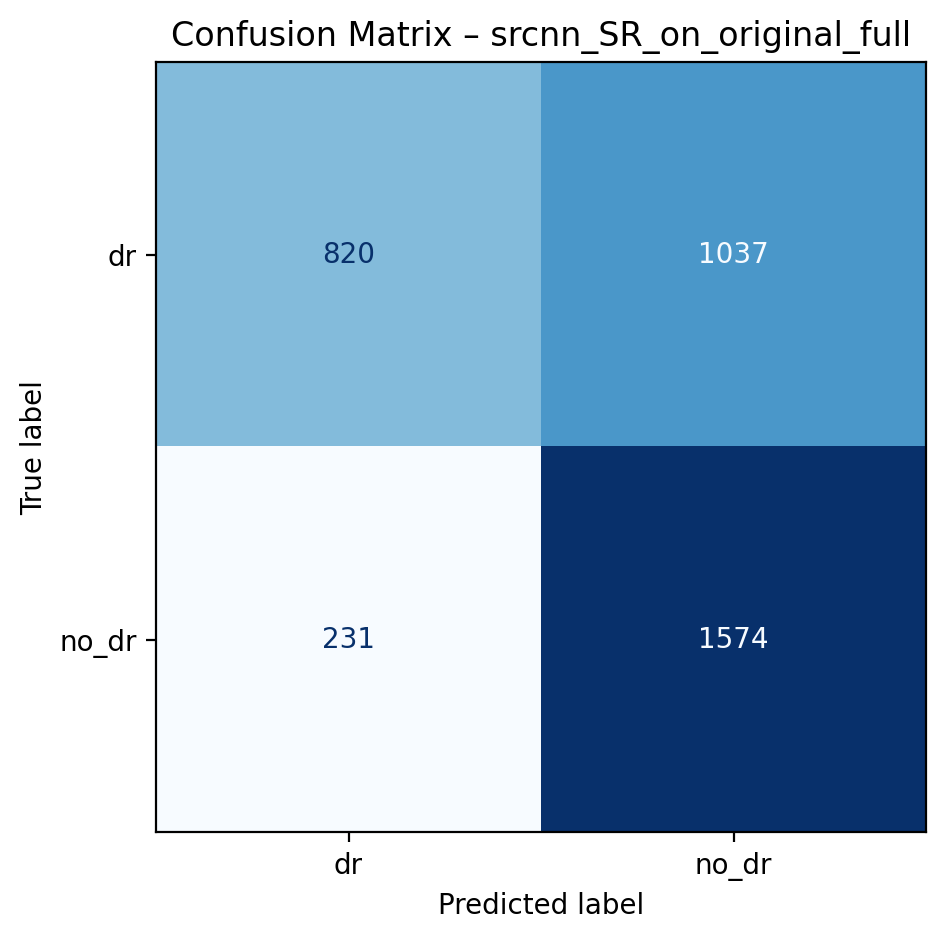

 RETCLIP finished srcnn_SR_on_original (full) in 1.5 min → acc=0.654, f1=0.638

=== BENCHMARK (full) COMPLETE (03:02:16) ===
   backbone              condition  mode       acc        f1  \
0      clip               original  full  0.722283  0.719967   
1      clip               degraded  full  0.654560  0.652147   
2      clip   espcn_SR_on_degraded  full  0.617695  0.599232   
3      clip   espcn_SR_on_original  full  0.629164  0.599925   
4      clip  fsrcnn_SR_on_degraded  full  0.492354  0.329918   
5      clip  fsrcnn_SR_on_original  full  0.490715  0.330126   
6      clip   srcnn_SR_on_degraded  full  0.639814  0.630839   
7      clip   srcnn_SR_on_original  full  0.653741  0.638412   
8   retclip               original  full  0.722283  0.719967   
9   retclip               degraded  full  0.654560  0.652147   
10  retclip   espcn_SR_on_degraded  full  0.617695  0.599232   
11  retclip   espcn_SR_on_original  full  0.629164  0.599925   
12  retclip  fsrcnn_SR_on_degraded  full  0

In [1]:
# ===============================================================
# PHASE 2 — APTOS Zero-Shot Learning (ZSL) Benchmark (CLIP + RETCLIP)
# ===============================================================
import os, sys, time, pandas as pd
from pathlib import Path
import torch

# --- ensure Honour project root is discoverable ---
project_root = Path(r"C:\Users\Jonathan Morel\Desktop\Honour")
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"[INFO] Added project root: {project_root}")

# --- load configuration ---
from src.config.loader import load_cfg
cfg = load_cfg(str(project_root / "config.yaml"))
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- import evaluation tools ---
from src.inference.eval_zsl import run_eval, load_eval_df

# ===============================================================
# OUTPUT FOLDERS
# ===============================================================
out_root = Path("outputs/metrics/APTOS_ZSL_Evaluation")
out_root.mkdir(parents=True, exist_ok=True)
sr_root = Path(cfg.paths.aptos_sr_root)

# ===============================================================
# TEST CONDITIONS (Original / Degraded / SR variants)
# ===============================================================
conditions = [
    ("original", Path(cfg.paths.aptos_original)),
    ("degraded", Path(cfg.paths.aptos_degraded)),
]

# --- automatically detect SR folders inside aptos_sr_root ---
if sr_root.exists():
    print(f"[DEBUG] Using SR root → {sr_root}")
    print("[DEBUG] Walking SR directories recursively:")
    for model_dir in sr_root.iterdir():
        if not model_dir.is_dir():
            continue
        for variant_dir in model_dir.iterdir():
            if variant_dir.is_dir() and any(x in variant_dir.name.lower() for x in ["sr_on_original", "sr_on_degraded"]):
                print(f"   > {variant_dir}")
                tag = f"{model_dir.name}_{variant_dir.name}"
                conditions.append((tag, variant_dir))
else:
    print(f" SR root does not exist — check config path.")

print(f"\nDetected {len(conditions)} datasets for evaluation:")
for tag, path in conditions:
    print(f" - {tag:25s} → {path}")

# ===============================================================
# BENCHMARK MODES
# ===============================================================
balance_modes = [
    ("balanced", getattr(cfg.eval, "binary_balance", 150)),
    ("full", None),
]

# ===============================================================
# CLASS CONFIG
# ===============================================================
classes = cfg.zsl.classes
prompt_ensemble = cfg.zsl.prompt_ensemble

# ===============================================================
# MAIN BENCHMARK LOOP
# ===============================================================
for mode_name, per_class in balance_modes:
    print(f"\n=== ZSL BENCHMARK ({mode_name.upper()}) STARTED ({time.strftime('%H:%M:%S')}) ===")

    mode_dir = out_root / mode_name
    mode_dir.mkdir(parents=True, exist_ok=True)

    labels_csv = Path(cfg.paths.aptos_labels)
    df_base = load_eval_df(str(labels_csv), str(cfg.paths.aptos_original), classes, per_class)
    results = []

    # --- Backbones: CLIP + RETCLIP ---
    for backbone in ["clip", "retclip"]:
        print(f"\n========== {backbone.upper()} ==========")
        for tag, img_dir in conditions:
            if not img_dir.exists():
                print(f"[WARN] Missing folder: {img_dir}")
                continue

            print(f"\n Running {backbone.upper()} on {tag} ({mode_name}) …")
            start = time.time()

            metrics = run_eval(
                backbone,
                df_base,
                img_dir,
                device,
                classes,
                prompt_ensemble,
                f"{tag}_{mode_name}"
            )

            duration = (time.time() - start) / 60
            acc = metrics.get("acc") or metrics.get("accuracy", 0.0)
            f1  = metrics.get("f1") or metrics.get("macro_f1", 0.0)

            results.append({
                "backbone": backbone,
                "condition": tag,
                "mode": mode_name,
                "acc": acc,
                "f1": f1,
                **{k: v for k, v in metrics.items() if k not in ["acc", "f1", "accuracy", "macro_f1"]}
            })

            if acc == 0 and f1 == 0:
                print(f" {backbone.upper()} skipped {tag} ({mode_name}) — no valid images or metrics.")
            else:
                print(f" {backbone.upper()} finished {tag} ({mode_name}) in {duration:.1f} min → acc={acc:.3f}, f1={f1:.3f}")

    # --- Save results per mode ---
    out_path = mode_dir / f"aptos_zsl_summary_{mode_name}.csv"
    results_df = pd.DataFrame(results)
    results_df.to_csv(out_path, index=False)
    print(f"\n=== BENCHMARK ({mode_name}) COMPLETE ({time.strftime('%H:%M:%S')}) ===")
    print(results_df)
    print(f"Results saved → {out_path}")

    # ===============================================================
    # SR ACCURACY GAIN SUMMARY
    # ===============================================================
    print("\n=== SR Accuracy Gains Summary ===")
    try:
        base_df = results_df[results_df["condition"].isin(["original", "degraded"])]
        sr_df   = results_df[~results_df["condition"].isin(["original", "degraded"])]

        gain_rows = []
        for _, sr_row in sr_df.iterrows():
            model_tag = sr_row["condition"]
            backbone  = sr_row["backbone"]
            acc       = sr_row["acc"]

            base_orig = base_df[(base_df["backbone"] == backbone) & (base_df["condition"] == "original")]["acc"]
            base_degr = base_df[(base_df["backbone"] == backbone) & (base_df["condition"] == "degraded")]["acc"]

            if not base_orig.empty and not base_degr.empty:
                gain_rows.append({
                    "backbone": backbone,
                    "SR_variant": model_tag,
                    "Gain_vs_Original": acc - base_orig.values[0],
                    "Gain_vs_Degraded": acc - base_degr.values[0],
                })

        gain_df = pd.DataFrame(gain_rows)
        gain_csv = mode_dir / f"aptos_zsl_sr_gains_{mode_name}.csv"
        gain_df.to_csv(gain_csv, index=False)

        if not gain_df.empty:
            print(gain_df)
            print(f"Gains saved → {gain_csv}")
        else:
            print("No SR datasets detected for gain comparison.")
    except Exception as e:
        print(f"[WARN] Could not compute SR gains: {e}")

print("\nAll outputs saved under → outputs/metrics/APTOS_ZSL_Evaluation/")


In [4]:
from pathlib import Path
from collections import Counter
from PIL import Image
import pandas as pd

# ================== EXACT SAME PATHS AS YOUR DL PIPELINE ==================

APTOS_ORIG = Path(r"C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\train_images")
IDRID_ORIG = Path(r"C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\1. Original Images")

IDRID_LABEL_CSV = Path(
    r"C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\2. Groundtruths\a. IDRiD_Disease Grading_Training Labels.csv"
)

VALID_EXT = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

# ================== LOAD LABELS ==================
idrid_df = pd.read_csv(IDRID_LABEL_CSV)
idrid_df.columns = [c.strip() for c in idrid_df.columns]
ID_COL = idrid_df.columns[0]
GRADE_COL = idrid_df.columns[1]
IDRID_LABEL_MAP = dict(zip(idrid_df[ID_COL], idrid_df[GRADE_COL]))

# APTOS: Subfolders 0/1/2/3/4 contain labelled images
def get_aptos_labels():
    label_map = {}
    for class_dir in APTOS_ORIG.iterdir():
        if class_dir.is_dir():
            try:
                lbl = int(class_dir.name)
            except ValueError:
                continue
            for p in class_dir.glob("*"):
                if p.suffix.lower() in VALID_EXT:
                    label_map[p.name] = lbl
    return label_map

APTOS_LABEL_MAP = get_aptos_labels()

# ================== IMAGE LISTING HELPERS ==================
def list_images(root: Path):
    return sorted([p for p in root.rglob("*") if p.suffix.lower() in VALID_EXT])

# ================== RESOLUTION SCANNER ==================
def scan_resolutions(paths):
    res = Counter()
    for p in paths:
        try:
            with Image.open(p) as im:
                res[(im.width, im.height)] += 1
        except:
            pass
    return res

# ================== APTOS STATS ==================
aptos_paths = list_images(APTOS_ORIG)
aptos_grades = [APTOS_LABEL_MAP[p.name] for p in aptos_paths if p.name in APTOS_LABEL_MAP]
aptos_grade_dist = Counter(aptos_grades)
aptos_res = scan_resolutions(aptos_paths)

# ================== IDRID STATS ==================
idrid_paths = list_images(IDRID_ORIG)
idrid_grades = [IDRID_LABEL_MAP[p.stem] for p in idrid_paths if p.stem in IDRID_LABEL_MAP]
idrid_grade_dist = Counter(idrid_grades)
idrid_res = scan_resolutions(idrid_paths)

# ================== PRINT RESULTS ==================
print("\n================ APTOS ================")
print(f"Total images: {len(aptos_paths)}")
print("Class distribution:", aptos_grade_dist)
print("Resolutions:")
for r, c in aptos_res.items():
    print(f"  {r[0]} × {r[1]} → {c}")

print("\n================ IDRiD ================")
print(f"Total images: {len(idrid_paths)}")
print("Class distribution:", idrid_grade_dist)
print("Resolutions:")
for r, c in idrid_res.items():
    print(f"  {r[0]} × {r[1]} → {c}")



================ APTOS ================
Total images: 3662
Class distribution: Counter()
Resolutions:
  3216 × 2136 → 410
  2416 × 1736 → 638
  1050 × 1050 → 974
  2048 × 1536 → 351
  3388 × 2588 → 141
  2588 × 1958 → 533
  819 × 614 → 287
  1504 × 1000 → 92
  1844 × 1226 → 61
  4288 × 2848 → 52
  640 × 480 → 42
  2896 × 1944 → 34
  2144 × 1424 → 28
  1476 × 1117 → 14
  474 × 358 → 2
  2146 × 1764 → 1
  1467 × 1110 → 2

================ IDRiD ================
Total images: 516
Class distribution: Counter({2: 182, 0: 134, 3: 101, 4: 77, 1: 22})
Resolutions:
  4288 × 2848 → 516


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load CSVs ===
aptos = pd.read_csv(r"C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\train.csv")
idrid = pd.read_csv(r"C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\2. Groundtruths\a. IDRiD_Disease Grading_Training Labels.csv")

# === Standardise column names ===
aptos_counts = aptos["diagnosis"].value_counts().sort_index()
idrid_counts = idrid.iloc[:, 1].value_counts().sort_index()   # 2nd column = Retinopathy grade

# ---------------------------------------------------------
# APTOS plot — saved separately
# ---------------------------------------------------------
plt.figure(figsize=(6, 5))
plt.bar(aptos_counts.index, aptos_counts.values)
plt.title("APTOS Class Distribution")
plt.xticks(range(5))
plt.xlabel("DR Severity (0–4)")
plt.ylabel("Image Count")
plt.tight_layout()
plt.savefig("aptos_class_dist.png", dpi=300)
plt.close()

# ---------------------------------------------------------
# IDRiD plot — saved separately
# ---------------------------------------------------------
plt.figure(figsize=(6, 5))
plt.bar(idrid_counts.index, idrid_counts.values)
plt.title("IDRiD Class Distribution")
plt.xticks(range(5))
plt.xlabel("DR Severity (0–4)")
plt.ylabel("Image Count")
plt.tight_layout()
plt.savefig("idrid_class_dist.png", dpi=300)
plt.close()

print("Saved: aptos_class_dist.png and idrid_class_dist.png")


Saved: aptos_class_dist.png and idrid_class_dist.png


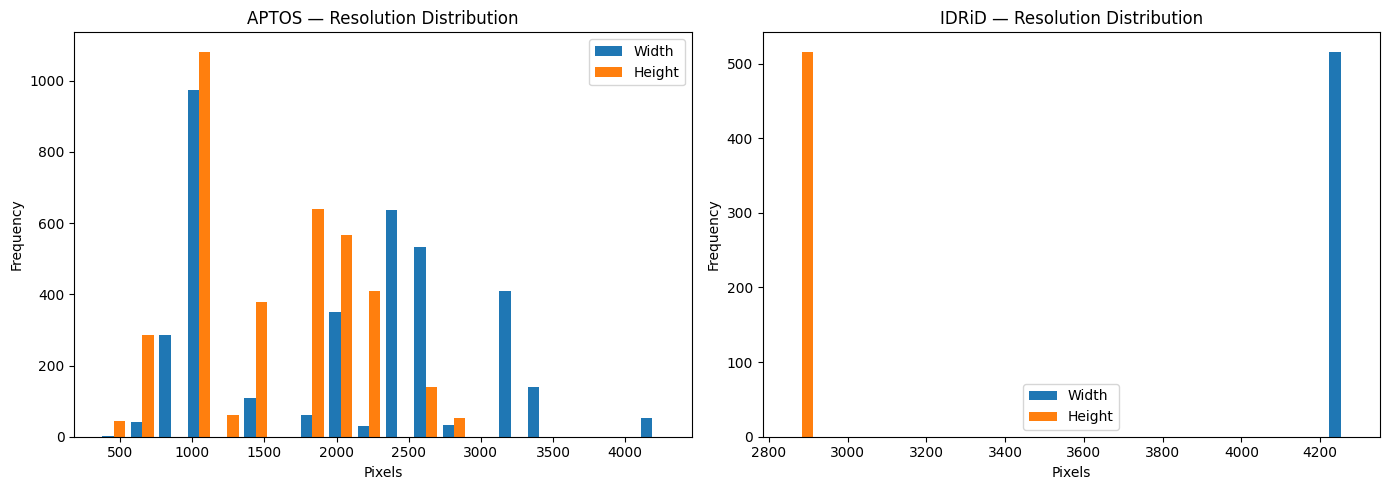

In [15]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

# === Paths ===
APTOS_DIR = Path(r"C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\train_images")
IDRID_DIR = Path(r"C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\1. Original Images")

VALID_EXT = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def get_resolutions(root: Path):
    widths, heights = [], []
    for p in root.rglob("*"):
        if p.suffix.lower() in VALID_EXT:
            try:
                w, h = Image.open(p).size
                widths.append(w)
                heights.append(h)
            except:
                pass
    return widths, heights

# Extract resolutions
aptos_w, aptos_h = get_resolutions(APTOS_DIR)
idrid_w, idrid_h = get_resolutions(IDRID_DIR)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist([aptos_w, aptos_h], bins=20, label=["Width", "Height"])
axes[0].set_title("APTOS — Resolution Distribution")
axes[0].set_xlabel("Pixels")
axes[0].set_ylabel("Frequency")
axes[0].legend()

axes[1].hist([idrid_w, idrid_h], bins=20, label=["Width", "Height"])
axes[1].set_title("IDRiD — Resolution Distribution")
axes[1].set_xlabel("Pixels")
axes[1].set_ylabel("Frequency")
axes[1].legend()

plt.tight_layout()
plt.savefig("resolutions_aptos_vs_idrid.png", dpi=300)
plt.show()


In [13]:
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import random

def build_montage(image_dir, csv_path, label_col_name, output_name):
    df = pd.read_csv(csv_path)
    df.columns = [c.strip() for c in df.columns]
    img_col = df.columns[0]
    grade_col = label_col_name

    fig, axes = plt.subplots(5, 5, figsize=(10, 10))   # 5 classes × 5 samples
    fig.suptitle(output_name.replace(".png",""), fontsize=14)

    for grade in range(5):
        candidates = df[df[grade_col] == grade][img_col].tolist()
        random.shuffle(candidates)
        selected = candidates[:5]

        for i, name in enumerate(selected):
            img_path = list(Path(image_dir).rglob(f"{name}.*"))[0]
            img = Image.open(img_path)
            axes[grade, i].imshow(img)
            axes[grade, i].axis("off")

    plt.tight_layout()
    plt.savefig(output_name, dpi=300)
    plt.close()

# Build APTOS montage
build_montage(
    r"C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\train_ready_512",
    r"C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\train.csv",
    "diagnosis",
    "montage_aptos.png"
)

# Build IDRiD montage
build_montage(
    r"C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\1. Original Images",
    r"C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\2. Groundtruths\a. IDRiD_Disease Grading_Training Labels.csv",
    "Retinopathy grade",
    "montage_idrid.png"
)


In [17]:
import pandas as pd

# Load full SR metrics file
df = pd.read_csv("sr_full_metrics.csv")

# Normalise column names (only if needed)
df.columns = [c.lower().strip() for c in df.columns]

# Compute mean and standard deviation per dataset × SR method
summary = (
    df.groupby(["dataset", "method"])
      .agg(
          psnr_mean=("psnr", "mean"),
          psnr_std=("psnr", "std"),
          ssim_mean=("ssim", "mean"),
          ssim_std=("ssim", "std")
      )
      .reset_index()
)

# Sort for readability
summary = summary.sort_values(["dataset", "psnr_mean"], ascending=[True, False])

print(summary.to_string(index=False))


dataset  method  psnr_mean  psnr_std  ssim_mean  ssim_std
  APTOS   srcnn  38.486929  1.484881   0.938604  0.021460
  APTOS bicubic  37.788342  0.907293   0.893852  0.007590
  APTOS   espcn  37.539968  1.931674   0.944137  0.017064
  APTOS  fsrcnn  31.378917  3.263635   0.871000  0.075718
  IDRID bicubic  38.311586  9.573986   0.890763  0.103603
  IDRID   srcnn  37.443723  9.158858   0.890613  0.102209
  IDRID   espcn  37.387184  9.121017   0.900932  0.109510
  IDRID  fsrcnn  31.623981  6.548370   0.819665  0.111379
